In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ase
import pandas as pd
import ase.io as aio

from easydict import EasyDict
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from models.guided_model import GuidedMolDiff, ScaleMode, NoiseSchedule, SiMGenGuidanceParams, ImportanceSamplingConfig
from models.bond_predictor import BondPredictor
from utils.sample import seperate_outputs
from utils.transforms import *
from utils.misc import *
from utils.reconstruct import *

from simgen.calculators import MaceSimilarityCalculator
from simgen.utils import setup_logger
from mace.calculators import mace_off
from ase.build import molecule
from pathlib import Path
from ase.optimize import FIRE

/home/rokas/miniconda3/envs/genesis/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.lo

In [2]:
setup_logger(tag="nb_test", directory="logs", level="DEBUG")

In [3]:
df = pd.read_csv("./fda_approved_drugs.txt", sep="\t")
df = df.query("~smiles.isna()")
mols = [Chem.MolFromSmiles(smi) for smi in df.smiles]

In [4]:
penicillin_smiles = df.query("generic_name == 'Penicillin G'")["smiles"].values[0]
penicillin_mol = Chem.MolFromSmiles(penicillin_smiles)
patt = Chem.MolFromSmarts("O=C1CC2N1CCS2")

In [5]:
has_patt = [mol.HasSubstructMatch(patt) for mol in mols]

In [6]:
np.where(has_patt)
penicillin_analogues = [mols[i] for i in np.where(has_patt)[0]]

In [7]:
core_ids = [m.GetSubstructMatch(patt) for m in penicillin_analogues]

In [8]:
core_ids[1]

(8, 7, 9, 0, 6, 5, 2, 1)

In [9]:
def rdkit2ase(mol):
    assert mol.GetNumConformers() > 0
    pos = mol.GetConformer().GetPositions()
    symbols = [a.GetSymbol() for a in mol.GetAtoms()]
    return ase.Atoms(positions=pos, symbols=symbols)

In [10]:
embedding_params = rdDistGeom.ETKDGv3()
for i, m in enumerate(penicillin_analogues):
    m = Chem.AddHs(m)
    rdDistGeom.EmbedMolecule(m, embedding_params)
    penicillin_analogues[i] = m
penicillin_analogues_ase = [rdkit2ase(m) for m in penicillin_analogues]

In [11]:
calc = mace_off("medium", device="cuda", default_dtype="float32")
z_table = calc.z_table
mace_model = calc.models[0]

Using MACE-OFF23 MODEL for MACECalculator with /home/rokas/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/rokas/miniconda3/envs/genesis/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

2024-12-23 19:02:15.311 INFO: CUDA version: 12.4, CUDA device: 0
Default dtype float32 does not match model dtype float64, converting models to float32.


In [12]:
# for m in penicillin_analogues_ase:
#     m.calc = calc
#     dyn = FIRE(m)
#     dyn.run(fmax=0.5)
#     m.calc = None

In [13]:
# aio.write("penicillin_analogues.xyz", penicillin_analogues_ase)
# np.save("penicillin_core_ids.npy", core_ids)

In [14]:
ref_atoms = aio.read("penicillin_analogues.xyz", index=":")
core_ids = np.load("penicillin_core_ids.npy")
core_masks = []
for atoms, mask in zip(ref_atoms, core_ids, strict=True):
    core_mask = np.zeros(len(atoms), dtype=bool)
    core_mask[mask] = True
    core_masks.append(core_mask)

In [15]:
ckpt = torch.load("./ckpt/MolDiff.pt", map_location="cuda")

/tmp/ipykernel_26511/3363570379.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./ckpt/MolDiff.pt", map_location="cuda")


In [16]:
train_config = ckpt["config"]
featurizer = FeaturizeMol(train_config.chem.atomic_numbers, train_config.chem.mol_bond_types,
                            use_mask_node=train_config.transform.use_mask_node,
                            use_mask_edge=train_config.transform.use_mask_edge,)

In [17]:
model = GuidedMolDiff(
    config=train_config.model,
    num_node_types=featurizer.num_node_types,
    num_edge_types=featurizer.num_edge_types,
).to("cuda")
model.load_state_dict(ckpt["model"])
model = model.eval()

In [18]:
element_sigma_array = np.ones_like(z_table.zs, dtype=np.float32)*1
sim_calc = MaceSimilarityCalculator(
    mace_model,
    reference_data=ref_atoms,
    ref_data_mask=core_masks,
    device="cuda",
    alpha=0,
    element_sigma_array=element_sigma_array,
    max_norm=None,
)

In [75]:
simgen_guidance_params = SiMGenGuidanceParams(
    sim_calc=sim_calc,
    node_to_element_map=featurizer.nodetype_to_ele,
    simgen_scale_mode=ScaleMode.FRACTIONAL,
    simgen_gui_scale=0.5,
    min_gui_scale=0.1,
    sigma_schedule_type=NoiseSchedule.CONSTANT,
    constant_sigma_value=2.,
)
importance_sampling_config = ImportanceSamplingConfig(
    frequency=10,
    inverse_temp=5e-3,
    mini_batch=4,
)

In [76]:
batch_holder = make_data_placeholder(n_graphs=16, device="cuda", max_size=14)
batch_node, halfedge_index, batch_halfedge = (
    batch_holder["batch_node"],
    batch_holder["halfedge_index"],
    batch_holder["batch_halfedge"],
)
outputs = model.sample(
    n_graphs=16,
    batch_node=batch_node,
    halfedge_index=halfedge_index,
    batch_halfedge=batch_halfedge,
    simgen_guidance_params=simgen_guidance_params,
    importance_sampling_params=importance_sampling_config,
)

  1%|          | 10/1000 [00:04<06:57,  2.37it/s]

2024-12-23 22:23:27.556 INFO: Importance sampling at step 10
2024-12-23 22:23:27.580 INFO: Log densities: tensor([-7135.4819, -3602.2856, -3674.7446, -3696.7817, -2643.6035, -2348.5850,
        -5529.1914, -4287.5605, -3651.2769, -3626.8159, -3796.3359, -3330.0627,
        -2472.7341, -5153.9648, -3666.4438, -3680.1582], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:27.592 INFO: Weights: tensor([[9.1698e-09, 4.3112e-01, 3.0009e-01, 2.6878e-01],
        [1.8616e-01, 8.1379e-01, 1.0091e-07, 5.0128e-05],
        [1.3162e-01, 1.4875e-01, 6.3729e-02, 6.5590e-01],
        [9.9508e-01, 1.4984e-06, 2.5454e-03, 2.3767e-03]], device='cuda:0')
2024-12-23 22:23:27.597 INFO: Selected batches: tensor([ 2,  3,  1,  3,  5,  5,  5,  5,  8, 11,  8, 11, 12, 12, 12, 12],
       device='cuda:0')


  2%|▏         | 20/1000 [00:08<06:02,  2.71it/s]

2024-12-23 22:23:31.180 INFO: Importance sampling at step 20
2024-12-23 22:23:31.186 INFO: Log densities: tensor([-3705.3149, -3695.7625, -2127.5244, -2768.4814, -4317.8408, -2378.8398,
        -3693.9287, -3585.9814, -3470.3638, -2834.8191, -4117.1211, -2099.1899,
        -3393.2688, -3676.8540, -3554.4060, -3647.9434], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:31.201 INFO: Weights: tensor([[3.5998e-04, 3.7759e-04, 9.6031e-01, 3.8957e-02],
        [6.1354e-05, 9.9617e-01, 1.3888e-03, 2.3826e-03],
        [1.0262e-03, 2.4621e-02, 4.0440e-05, 9.7431e-01],
        [5.0790e-01, 1.2302e-01, 2.2692e-01, 1.4215e-01]], device='cuda:0')
2024-12-23 22:23:31.205 INFO: Selected batches: tensor([ 2,  2,  2,  2,  5,  5,  5,  5, 11, 11, 11, 11, 12, 15, 12, 12],
       device='cuda:0')


  3%|▎         | 30/1000 [00:12<05:44,  2.82it/s]

2024-12-23 22:23:35.003 INFO: Importance sampling at step 30
2024-12-23 22:23:35.008 INFO: Log densities: tensor([-2313.5417, -3717.4719, -2568.9614, -2629.7676, -2660.7205, -3687.0112,
        -3540.7725, -3076.7764, -3167.3940, -2583.2559, -2752.2532, -3910.9277,
        -2754.4172, -3678.7993, -3494.4961, -3372.1465], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:35.014 INFO: Weights: tensor([[6.7318e-01, 6.0192e-04, 1.8771e-01, 1.3850e-01],
        [8.7483e-01, 5.1685e-03, 1.0738e-02, 1.0926e-01],
        [3.6300e-02, 6.7351e-01, 2.8931e-01, 8.8174e-04],
        [9.2583e-01, 9.1046e-03, 2.2881e-02, 4.2184e-02]], device='cuda:0')
2024-12-23 22:23:35.017 INFO: Selected batches: tensor([ 0,  2,  0,  0,  7,  4,  4,  4,  9,  8, 10,  9, 12, 12, 12, 12],
       device='cuda:0')


  4%|▍         | 40/1000 [00:15<06:27,  2.48it/s]

2024-12-23 22:23:38.817 INFO: Importance sampling at step 40
2024-12-23 22:23:38.823 INFO: Log densities: tensor([-2431.9370, -3711.3721, -2213.9209, -3388.4668, -2723.1980, -2753.7368,
        -2579.0801, -3647.7476, -3750.7473, -2461.2935, -3580.2185, -2362.2178,
        -2437.8059, -3586.4456, -3494.6355, -3633.5071], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:38.830 INFO: Weights: tensor([[2.5097e-01, 4.1818e-04, 7.4651e-01, 2.1016e-03],
        [2.5485e-01, 2.1876e-01, 5.2388e-01, 2.5041e-03],
        [5.9886e-04, 3.7787e-01, 1.4048e-03, 6.2013e-01],
        [9.8931e-01, 3.1702e-03, 5.0171e-03, 2.5055e-03]], device='cuda:0')
2024-12-23 22:23:38.835 INFO: Selected batches: tensor([ 2,  2,  2,  2,  6,  6,  4,  6,  9, 11, 11,  9, 12, 12, 12, 12],
       device='cuda:0')


  5%|▌         | 50/1000 [00:19<05:38,  2.81it/s]

2024-12-23 22:23:42.527 INFO: Importance sampling at step 50
2024-12-23 22:23:42.533 INFO: Log densities: tensor([-3663.6284, -4371.9663, -2444.7678, -2219.9602, -3583.7395, -2426.3455,
        -3495.6914, -3620.8711, -2150.4060, -2362.3008, -2646.0735, -1943.4684,
        -3076.9470, -3188.4160, -3469.1807, -2689.3005], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:42.538 INFO: Weights: tensor([[5.5292e-04, 1.6015e-05, 2.4512e-01, 7.5431e-01],
        [3.0358e-03, 9.8973e-01, 4.7148e-03, 2.5214e-03],
        [2.3559e-01, 8.1663e-02, 1.9761e-02, 6.6299e-01],
        [1.1547e-01, 6.6136e-02, 1.6247e-02, 8.0214e-01]], device='cuda:0')
2024-12-23 22:23:42.542 INFO: Selected batches: tensor([ 2,  3,  3,  3,  5,  5,  5,  5,  8, 11,  8, 11, 13, 15, 15, 12],
       device='cuda:0')


  6%|▌         | 60/1000 [00:23<05:30,  2.85it/s]

2024-12-23 22:23:46.195 INFO: Importance sampling at step 60
2024-12-23 22:23:46.200 INFO: Log densities: tensor([-3906.1460, -3644.0803, -2827.6587, -2290.2124, -3108.9121, -2526.3457,
        -3406.7620, -3600.9307, -2203.8811, -2897.8022, -2842.2402, -1881.9519,
        -1930.6183, -2618.8074, -3250.3499, -2559.7634], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:46.207 INFO: Weights: tensor([[2.8964e-04, 1.0738e-03, 6.3644e-02, 9.3499e-01],
        [5.0710e-02, 9.3352e-01, 1.1437e-02, 4.3320e-03],
        [1.6466e-01, 5.1256e-03, 6.7670e-03, 8.2345e-01],
        [9.2899e-01, 2.9760e-02, 1.2655e-03, 3.9980e-02]], device='cuda:0')
2024-12-23 22:23:46.211 INFO: Selected batches: tensor([ 3,  3,  3,  3,  5,  5,  6,  5,  8, 11, 11, 11, 12, 12, 12, 12],
       device='cuda:0')


  7%|▋         | 70/1000 [00:26<05:32,  2.80it/s]

2024-12-23 22:23:49.858 INFO: Importance sampling at step 70
2024-12-23 22:23:49.864 INFO: Log densities: tensor([-2493.1536, -3645.4072, -2202.2336, -1775.6293, -2671.1592, -3188.9753,
        -2355.6597, -3084.1211, -3233.6987, -2496.8955, -2158.7285, -2500.0303,
        -1216.5708, -2332.2051, -2195.4976, -2554.4829], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:49.870 INFO: Weights: tensor([[2.4135e-02, 7.5955e-05, 1.0336e-01, 8.7243e-01],
        [1.6543e-01, 1.2422e-02, 8.0116e-01, 2.0984e-02],
        [3.3795e-03, 1.3452e-01, 7.2966e-01, 1.3243e-01],
        [9.8764e-01, 3.7328e-03, 7.3941e-03, 1.2285e-03]], device='cuda:0')
2024-12-23 22:23:49.875 INFO: Selected batches: tensor([ 3,  3,  0,  3,  6,  6,  6,  6, 10,  9, 10, 10, 12, 12, 12, 12],
       device='cuda:0')


  8%|▊         | 80/1000 [00:30<05:33,  2.76it/s]

2024-12-23 22:23:53.481 INFO: Importance sampling at step 80
2024-12-23 22:23:53.490 INFO: Log densities: tensor([-3305.5435, -3645.7632, -2228.7295, -3536.6892, -1353.6385, -5138.9941,
        -2498.8477, -3591.5798, -2459.4675, -2744.9963, -2017.4575, -4336.3447,
        -2191.9365, -2200.9961, -2086.2698, -2502.1938], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:53.496 INFO: Weights: tensor([[4.5578e-03, 8.3172e-04, 9.9318e-01, 1.4349e-03],
        [9.9674e-01, 6.0088e-09, 3.2493e-03, 1.3771e-05],
        [9.6561e-02, 2.3162e-02, 8.8027e-01, 8.1136e-06],
        [2.5881e-01, 2.4735e-01, 4.3897e-01, 5.4862e-02]], device='cuda:0')
2024-12-23 22:23:53.500 INFO: Selected batches: tensor([ 2,  2,  2,  2,  4,  4,  4,  4, 10, 10, 10, 10, 12, 14, 12, 14],
       device='cuda:0')


  9%|▉         | 90/1000 [00:34<05:51,  2.59it/s]

2024-12-23 22:23:57.280 INFO: Importance sampling at step 90
2024-12-23 22:23:57.287 INFO: Log densities: tensor([-2694.5142, -3457.5791, -2310.5796, -2370.4780, -2871.5176, -3053.6309,
        -2215.7710, -2212.3057, -2540.2354, -2329.3594, -1728.5115, -2202.5684,
        -1937.9072, -3150.3303, -3040.0391, -2402.6958], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:23:57.294 INFO: Weights: tensor([[0.0776, 0.0017, 0.5288, 0.3919],
        [0.0182, 0.0073, 0.4830, 0.4915],
        [0.0149, 0.0427, 0.8618, 0.0805],
        [0.9056, 0.0021, 0.0037, 0.0886]], device='cuda:0')
2024-12-23 22:23:57.298 INFO: Selected batches: tensor([ 0,  2,  2,  2,  6,  6,  7,  6,  9,  9, 10, 10, 12, 12, 12, 12],
       device='cuda:0')


 10%|█         | 100/1000 [00:38<06:15,  2.40it/s]

2024-12-23 22:24:01.598 INFO: Importance sampling at step 100
2024-12-23 22:24:01.603 INFO: Log densities: tensor([-2335.1887, -3615.3291, -2797.4109, -2446.6902, -1660.6906, -4306.2163,
        -2281.8647, -2312.3743, -2312.8774, -2664.4241, -2497.7424, -2568.5049,
        -3552.6731, -2945.9758, -3613.8496, -2932.7612], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:01.612 INFO: Weights: tensor([[5.9757e-01, 9.9220e-04, 5.9250e-02, 3.4219e-01],
        [9.2316e-01, 1.6618e-06, 4.1344e-02, 3.5495e-02],
        [5.4119e-01, 9.3320e-02, 2.1474e-01, 1.5075e-01],
        [2.2374e-02, 4.6470e-01, 1.6478e-02, 4.9644e-01]], device='cuda:0')
2024-12-23 22:24:01.618 INFO: Selected batches: tensor([ 3,  3,  2,  3,  4,  6,  4,  4,  8,  9, 10,  8, 15, 13, 15, 15],
       device='cuda:0')


 11%|█         | 110/1000 [00:42<05:51,  2.53it/s]

2024-12-23 22:24:05.561 INFO: Importance sampling at step 110
2024-12-23 22:24:05.566 INFO: Log densities: tensor([-2108.5947, -2901.6860, -1546.3350, -1972.7740, -1661.9214, -3191.4080,
        -1729.5903, -2255.3018, -4051.8911, -2281.9736, -1879.6191, -2429.4734,
        -1771.7596, -2826.3655, -2555.7686, -3341.6685], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:05.572 INFO: Weights: tensor([[5.0962e-02, 9.6620e-04, 8.4757e-01, 1.0050e-01],
        [5.6661e-01, 2.7042e-04, 4.0396e-01, 2.9159e-02],
        [1.6018e-05, 1.1167e-01, 8.3490e-01, 5.3412e-02],
        [9.7527e-01, 5.0012e-03, 1.9350e-02, 3.8029e-04]], device='cuda:0')
2024-12-23 22:24:05.577 INFO: Selected batches: tensor([ 2,  2,  2,  2,  6,  4,  4,  4,  9, 10, 10,  9, 12, 12, 12, 12],
       device='cuda:0')


 12%|█▏        | 120/1000 [00:46<05:28,  2.68it/s]

2024-12-23 22:24:09.237 INFO: Importance sampling at step 120
2024-12-23 22:24:09.242 INFO: Log densities: tensor([-2358.3149, -2043.0643, -1240.7117, -3221.5737, -2835.9868, -2157.3247,
        -2401.3762, -3583.0879, -3349.5815, -1841.5582, -2163.0620, -2290.0583,
        -1174.3042, -3524.9214, -2137.2583, -2546.2834], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:09.248 INFO: Weights: tensor([[3.6623e-03, 1.7714e-02, 9.7858e-01, 4.8889e-05],
        [2.5270e-02, 7.5213e-01, 2.2199e-01, 6.0296e-04],
        [4.0650e-04, 7.6505e-01, 1.5330e-01, 8.1242e-02],
        [9.9092e-01, 7.7936e-06, 8.0354e-03, 1.0395e-03]], device='cuda:0')
2024-12-23 22:24:09.253 INFO: Selected batches: tensor([ 2,  2,  2,  2,  5,  5,  5,  5,  9,  9,  9,  9, 12, 12, 12, 12],
       device='cuda:0')


 13%|█▎        | 130/1000 [00:50<06:07,  2.37it/s]

2024-12-23 22:24:13.448 INFO: Importance sampling at step 130
2024-12-23 22:24:13.457 INFO: Log densities: tensor([-2213.5024, -1895.5564, -1512.1316, -2217.1782, -1795.5861, -2410.0620,
        -2215.2961, -2028.0549, -2295.6804, -2595.9749, -1645.2471, -1757.6030,
        -1103.9771, -3406.8691, -2205.3174, -2855.3052], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:13.474 INFO: Weights: tensor([[2.4859e-02, 1.2187e-01, 8.2887e-01, 2.4406e-02],
        [6.7490e-01, 3.1255e-02, 8.2766e-02, 2.1108e-01],
        [2.3920e-02, 5.3294e-03, 6.1824e-01, 3.5251e-01],
        [9.9579e-01, 9.9426e-06, 4.0424e-03, 1.5675e-04]], device='cuda:0')
2024-12-23 22:24:13.478 INFO: Selected batches: tensor([ 2,  2,  2,  2,  4,  4,  4,  7, 10, 10, 10, 10, 12, 12, 12, 12],
       device='cuda:0')


 14%|█▍        | 140/1000 [00:54<05:15,  2.72it/s]

2024-12-23 22:24:17.337 INFO: Importance sampling at step 140
2024-12-23 22:24:17.343 INFO: Log densities: tensor([-2375.7532, -2227.0103, -2403.4932, -2185.7002, -1932.5386, -2366.4956,
        -1906.6559, -2578.4153, -3025.2004, -2820.1575, -1781.6243, -2297.3711,
        -2331.8105, -3637.0811, -3209.8240, -2758.7656], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:17.357 INFO: Weights: tensor([[0.1524, 0.3207, 0.1327, 0.3942],
        [0.4363, 0.0498, 0.4966, 0.0173],
        [0.0018, 0.0051, 0.9230, 0.0700],
        [0.8833, 0.0013, 0.0110, 0.1045]], device='cuda:0')
2024-12-23 22:24:17.362 INFO: Selected batches: tensor([ 3,  1,  1,  2,  4,  4,  6,  4, 10, 10, 10, 10, 15, 12, 12, 12],
       device='cuda:0')


 15%|█▌        | 150/1000 [00:58<05:34,  2.54it/s]

2024-12-23 22:24:21.486 INFO: Importance sampling at step 150
2024-12-23 22:24:21.492 INFO: Log densities: tensor([-3655.7068, -2316.2695, -1690.0719, -2830.4829, -2210.3794, -2347.9807,
        -1821.4945, -3006.5232, -2273.0762, -2165.6611, -1396.4572, -1738.6162,
        -1751.0476, -1842.3552, -3821.8752, -1731.0127], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:21.498 INFO: Weights: tensor([[5.1488e-05, 4.1711e-02, 9.5505e-01, 3.1890e-03],
        [1.1750e-01, 5.9051e-02, 8.2126e-01, 2.1939e-03],
        [1.0281e-02, 1.7590e-02, 8.2333e-01, 1.4879e-01],
        [3.6511e-01, 2.3129e-01, 1.1633e-05, 4.0358e-01]], device='cuda:0')
2024-12-23 22:24:21.502 INFO: Selected batches: tensor([ 2,  2,  2,  2,  6,  6,  6,  6, 10, 11, 11, 10, 15, 12, 12, 15],
       device='cuda:0')


 16%|█▌        | 160/1000 [01:02<05:24,  2.59it/s]

2024-12-23 22:24:25.395 INFO: Importance sampling at step 160
2024-12-23 22:24:25.402 INFO: Log densities: tensor([-2280.6113, -1391.1378, -1563.4077, -2085.0952, -1619.1443, -2478.6729,
        -2456.6558, -2141.1814, -2221.6829, -2290.2244, -1314.2764, -1276.5018,
        -2127.9158, -1877.0157, -2123.3555, -2059.8530], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:25.416 INFO: Weights: tensor([[0.0080, 0.6824, 0.2884, 0.0212],
        [0.9072, 0.0123, 0.0138, 0.0667],
        [0.0048, 0.0034, 0.4492, 0.5426],
        [0.1442, 0.5056, 0.1475, 0.2027]], device='cuda:0')
2024-12-23 22:24:25.423 INFO: Selected batches: tensor([ 1,  1,  2,  1,  4,  4,  4,  4, 10, 10, 11, 11, 13, 13, 15, 13],
       device='cuda:0')


 17%|█▋        | 170/1000 [01:07<06:50,  2.02it/s]

2024-12-23 22:24:30.143 INFO: Importance sampling at step 170
2024-12-23 22:24:30.150 INFO: Log densities: tensor([-1558.1581, -1615.7422, -1312.8145, -2330.6274, -1807.7378, -2647.6431,
        -1473.1812, -2300.0212, -2213.3213, -2326.5239, -1493.2678, -1736.6954,
        -2146.0720, -2254.0029, -2349.6082, -1856.0000], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:30.157 INFO: Weights: tensor([[0.1930, 0.1447, 0.6582, 0.0041],
        [0.1556, 0.0023, 0.8288, 0.0133],
        [0.0204, 0.0116, 0.7469, 0.2211],
        [0.1611, 0.0939, 0.0582, 0.6868]], device='cuda:0')
2024-12-23 22:24:30.163 INFO: Selected batches: tensor([ 2,  2,  2,  2,  4,  6,  4,  6, 10, 10, 11, 10, 13, 15, 12, 12],
       device='cuda:0')


 18%|█▊        | 180/1000 [01:10<04:48,  2.84it/s]

2024-12-23 22:24:33.724 INFO: Importance sampling at step 180
2024-12-23 22:24:33.729 INFO: Log densities: tensor([ -931.3876, -1899.3884, -1856.9755, -1851.2935, -1579.4247, -2443.5063,
        -3549.6394, -2543.7334, -2933.2725, -2160.2549, -1846.0381, -1213.0848,
        -2203.2419, -1837.2311, -2361.4829, -2637.9094], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:33.734 INFO: Weights: tensor([[9.7301e-01, 7.6936e-03, 9.5111e-03, 9.7851e-03],
        [9.7905e-01, 1.3016e-02, 5.1587e-05, 7.8856e-03],
        [1.7498e-04, 8.3477e-03, 4.0168e-02, 9.5131e-01],
        [1.2818e-01, 7.9912e-01, 5.8105e-02, 1.4587e-02]], device='cuda:0')
2024-12-23 22:24:33.738 INFO: Selected batches: tensor([ 0,  0,  0,  0,  4,  4,  4,  4, 11, 11, 11, 11, 13, 12, 12, 12],
       device='cuda:0')


 19%|█▉        | 190/1000 [01:14<05:13,  2.58it/s]

2024-12-23 22:24:37.547 INFO: Importance sampling at step 190
2024-12-23 22:24:37.553 INFO: Log densities: tensor([-1241.9316, -1217.5437,  -987.0025, -1399.3611, -3620.7842, -2315.8325,
        -1267.3665, -2253.6143, -1781.8555, -1947.8015, -1330.1001, -1869.1748,
        -2099.5405, -2471.9985, -1601.3477, -2082.2505], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:37.558 INFO: Weights: tensor([[1.6228e-01, 1.8332e-01, 5.8054e-01, 7.3859e-02],
        [7.6598e-06, 5.2226e-03, 9.8764e-01, 7.1284e-03],
        [8.5809e-02, 3.7427e-02, 8.2131e-01, 5.5453e-02],
        [6.9840e-02, 1.0847e-02, 8.4317e-01, 7.6146e-02]], device='cuda:0')
2024-12-23 22:24:37.561 INFO: Selected batches: tensor([ 2,  2,  2,  2,  6,  6,  6,  6, 10, 10, 10, 10, 14, 14, 14, 14],
       device='cuda:0')


 20%|██        | 200/1000 [01:18<05:05,  2.62it/s]

2024-12-23 22:24:41.510 INFO: Importance sampling at step 200
2024-12-23 22:24:41.517 INFO: Log densities: tensor([-1724.3203, -2229.1821, -2537.5725, -2474.5283, -1749.1425, -2405.5947,
        -1193.4624, -2159.4353, -2529.8320, -2223.1260, -1636.9656, -1406.1948,
        -1864.7206, -1823.4471, -2789.1257, -2203.9924], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:41.528 INFO: Weights: tensor([[0.8923, 0.0715, 0.0153, 0.0210],
        [0.0579, 0.0022, 0.9324, 0.0074],
        [0.0027, 0.0126, 0.2361, 0.7486],
        [0.4128, 0.5074, 0.0041, 0.0757]], device='cuda:0')
2024-12-23 22:24:41.534 INFO: Selected batches: tensor([ 0,  0,  0,  0,  6,  6,  6,  6, 11, 11, 10, 10, 13, 12, 13, 13],
       device='cuda:0')


 21%|██        | 210/1000 [01:22<04:42,  2.80it/s]

2024-12-23 22:24:45.209 INFO: Importance sampling at step 210
2024-12-23 22:24:45.214 INFO: Log densities: tensor([-1705.1285, -1582.3724, -1251.8481, -1067.6924, -1341.0417, -2175.9883,
        -2334.5586, -3544.1309, -1996.9648, -2110.0520, -1612.7203, -2718.2681,
        -1974.9337, -1674.2990, -1355.0854, -2264.1555], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:45.219 INFO: Weights: tensor([[2.7239e-02, 5.0321e-02, 2.6271e-01, 6.5973e-01],
        [9.7813e-01, 1.5043e-02, 6.8078e-03, 1.6086e-05],
        [1.1870e-01, 6.7435e-02, 8.1064e-01, 3.2223e-03],
        [3.5826e-02, 1.6107e-01, 7.9467e-01, 8.4365e-03]], device='cuda:0')
2024-12-23 22:24:45.223 INFO: Selected batches: tensor([ 3,  2,  2,  3,  4,  4,  4,  4, 10, 10, 10, 10, 14, 14, 14, 14],
       device='cuda:0')


 22%|██▏       | 220/1000 [01:26<05:21,  2.43it/s]

2024-12-23 22:24:49.221 INFO: Importance sampling at step 220
2024-12-23 22:24:49.230 INFO: Log densities: tensor([-2210.8418, -1276.1250, -1418.4346, -1297.1527, -2806.6982, -2111.3630,
        -2122.7446, -3546.1646, -2323.3542, -2777.5376, -2156.8843, -2301.3232,
        -1964.8378, -1717.1477, -1211.2870, -2232.2461], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:49.238 INFO: Weights: tensor([[3.8905e-03, 4.1659e-01, 2.0450e-01, 3.7502e-01],
        [1.5640e-02, 5.0598e-01, 4.7799e-01, 3.8771e-04],
        [2.2132e-01, 2.2844e-02, 5.0875e-01, 2.4709e-01],
        [2.0835e-02, 7.1887e-02, 9.0181e-01, 5.4718e-03]], device='cuda:0')
2024-12-23 22:24:49.244 INFO: Selected batches: tensor([ 3,  1,  3,  2,  5,  6,  6,  5, 10, 10, 10, 10, 14, 14, 14, 14],
       device='cuda:0')


 23%|██▎       | 230/1000 [01:30<05:02,  2.54it/s]

2024-12-23 22:24:53.319 INFO: Importance sampling at step 230
2024-12-23 22:24:53.325 INFO: Log densities: tensor([-2223.7939, -1315.8422, -1646.9326, -1162.7615, -1294.5378, -2121.9880,
        -1851.7517, -3596.3860, -1948.4554, -2218.5703, -1874.1945, -2907.0051,
        -1951.2177, -1443.2812, -1151.5327, -2272.0630], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:53.331 INFO: Weights: tensor([[3.1854e-03, 2.9837e-01, 5.6990e-02, 6.4145e-01],
        [9.2795e-01, 1.4816e-02, 5.7221e-02, 9.3138e-06],
        [3.6805e-01, 9.5359e-02, 5.3354e-01, 3.0510e-03],
        [1.4622e-02, 1.8535e-01, 7.9709e-01, 2.9397e-03]], device='cuda:0')
2024-12-23 22:24:53.334 INFO: Selected batches: tensor([ 2,  2,  3,  3,  4,  4,  4,  4,  9,  8,  8,  8, 14, 14, 14, 14],
       device='cuda:0')


 24%|██▍       | 240/1000 [01:34<04:38,  2.73it/s]

2024-12-23 22:24:57.106 INFO: Importance sampling at step 240
2024-12-23 22:24:57.113 INFO: Log densities: tensor([-1820.4446, -2081.2456, -2235.7422, -1531.3240, -1306.7565, -2223.9758,
        -1584.2200, -2075.1394, -1928.5823, -2284.2390, -1325.4268, -2409.0957,
        -1765.3015, -2312.1841, -2275.9729, -1841.2708], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:24:57.120 INFO: Weights: tensor([[0.1773, 0.0481, 0.0222, 0.7524],
        [0.7804, 0.0080, 0.1949, 0.0167],
        [0.0462, 0.0078, 0.9419, 0.0042],
        [0.5474, 0.0355, 0.0426, 0.3744]], device='cuda:0')
2024-12-23 22:24:57.125 INFO: Selected batches: tensor([ 3,  3,  3,  3,  4,  7,  4,  4, 10, 10, 10, 10, 15, 12, 15, 15],
       device='cuda:0')


 25%|██▌       | 250/1000 [01:38<04:36,  2.72it/s]

2024-12-23 22:25:00.997 INFO: Importance sampling at step 250
2024-12-23 22:25:01.002 INFO: Log densities: tensor([-1986.2817, -1243.4202, -1756.1305, -1969.2505, -2608.2493, -1791.3845,
        -2094.3628, -2321.4663, -1661.5276, -2267.8345, -1120.9985, -1349.7069,
        -1459.0409, -1658.2325, -1384.6627, -1377.1719], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:01.007 INFO: Weights: tensor([[0.0216, 0.8866, 0.0683, 0.0235],
        [0.0129, 0.7649, 0.1682, 0.0540],
        [0.0483, 0.0023, 0.7200, 0.2294],
        [0.2312, 0.0854, 0.3353, 0.3481]], device='cuda:0')
2024-12-23 22:25:01.010 INFO: Selected batches: tensor([ 1,  2,  1,  1,  5,  5,  5,  5, 10, 10, 10, 10, 14, 12, 13, 12],
       device='cuda:0')


 26%|██▌       | 260/1000 [01:41<04:13,  2.91it/s]

2024-12-23 22:25:04.549 INFO: Importance sampling at step 260
2024-12-23 22:25:04.555 INFO: Log densities: tensor([-1568.5660, -1569.9375, -2239.8062, -1627.9281, -1216.0322, -2689.6445,
        -1748.0057, -2114.8638, -1560.4271, -2029.4484, -1119.9360, -1229.4574,
        -1674.1780, -1929.4307, -1401.0679, -1202.0981], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:04.560 INFO: Weights: tensor([[3.6085e-01, 3.5839e-01, 1.2582e-02, 2.6818e-01],
        [9.2442e-01, 5.8339e-04, 6.4670e-02, 1.0330e-02],
        [6.5039e-02, 6.2332e-03, 5.8842e-01, 3.4030e-01],
        [6.3323e-02, 1.7672e-02, 2.4809e-01, 6.7091e-01]], device='cuda:0')
2024-12-23 22:25:04.564 INFO: Selected batches: tensor([ 0,  3,  0,  0,  4,  4,  4,  4,  8, 11, 10, 10, 15, 15, 14, 15],
       device='cuda:0')


 27%|██▋       | 270/1000 [01:45<04:19,  2.81it/s]

2024-12-23 22:25:08.149 INFO: Importance sampling at step 270
2024-12-23 22:25:08.156 INFO: Log densities: tensor([-1697.6838, -1724.7781, -2173.1333, -1422.8215, -2725.5747, -2319.7739,
        -1887.2490, -2088.0686, -2432.1912, -2071.0024, -1700.5616, -1439.5204,
        -1809.3350, -1225.6799, -2234.1116, -1232.5771], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:08.162 INFO: Weights: tensor([[0.1690, 0.1476, 0.0157, 0.6678],
        [0.0101, 0.0769, 0.6682, 0.2448],
        [0.0053, 0.0322, 0.2053, 0.7572],
        [0.0267, 0.4934, 0.0032, 0.4767]], device='cuda:0')
2024-12-23 22:25:08.167 INFO: Selected batches: tensor([ 3,  3,  1,  3,  6,  7,  6,  6, 10, 10, 10, 10, 13, 15, 15, 13],
       device='cuda:0')


 28%|██▊       | 280/1000 [01:48<03:57,  3.03it/s]

2024-12-23 22:25:11.487 INFO: Importance sampling at step 280
2024-12-23 22:25:11.494 INFO: Log densities: tensor([-1360.1544, -2276.3335, -2462.3735, -1177.6917, -2243.5732, -2338.6221,
        -1763.1459, -1965.1998, -2055.4360, -2758.5308, -1040.9319, -1378.0242,
        -1810.3789, -2012.8615, -1347.9167, -1022.9056], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:11.500 INFO: Weights: tensor([[2.8536e-01, 2.9237e-03, 1.1533e-03, 7.1056e-01],
        [5.9913e-02, 3.7250e-02, 6.6185e-01, 2.4099e-01],
        [5.2581e-03, 1.5634e-04, 8.3906e-01, 1.5553e-01],
        [1.5938e-02, 5.7908e-03, 1.6093e-01, 8.1734e-01]], device='cuda:0')
2024-12-23 22:25:11.503 INFO: Selected batches: tensor([ 3,  3,  3,  3,  7,  6,  6,  6, 10, 10, 11, 10, 15, 15, 15, 15],
       device='cuda:0')


 29%|██▉       | 290/1000 [01:51<03:56,  3.00it/s]

2024-12-23 22:25:14.988 INFO: Importance sampling at step 290
2024-12-23 22:25:14.994 INFO: Log densities: tensor([-1311.4298, -1204.7837, -2513.9961, -1188.8784, -1305.9458, -1940.4562,
        -1520.4175, -3162.7346, -1266.5865, -2275.6221, -1610.4143, -1357.4832,
        -1656.2095, -1826.6426, -2610.5889, -1213.3823], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:15.000 INFO: Weights: tensor([[2.1966e-01, 3.7440e-01, 5.3755e-04, 4.0539e-01],
        [7.2244e-01, 3.0268e-02, 2.4722e-01, 6.7118e-05],
        [5.4932e-01, 3.5378e-03, 9.8449e-02, 3.4869e-01],
        [9.4443e-02, 4.0279e-02, 7.9939e-04, 8.6448e-01]], device='cuda:0')
2024-12-23 22:25:15.005 INFO: Selected batches: tensor([ 3,  0,  1,  3,  4,  4,  6,  4, 11,  8, 10, 11, 15, 15, 15, 15],
       device='cuda:0')


 30%|███       | 300/1000 [01:55<03:45,  3.11it/s]

2024-12-23 22:25:18.309 INFO: Importance sampling at step 300
2024-12-23 22:25:18.314 INFO: Log densities: tensor([-1560.9558, -1286.0060,  -994.8367, -2362.1631, -1366.0383, -2216.7461,
        -1109.9257, -2610.0364, -2721.5459, -2303.2915, -1771.1471, -2255.0608,
        -1660.7345, -1446.8298, -1737.0596, -1323.2468], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:18.319 INFO: Weights: tensor([[4.5604e-02, 1.8032e-01, 7.7324e-01, 8.3024e-04],
        [2.1669e-01, 3.0800e-03, 7.7980e-01, 4.3106e-04],
        [7.3957e-03, 5.9870e-02, 8.5654e-01, 7.6197e-02],
        [9.9976e-02, 2.9133e-01, 6.8259e-02, 5.4043e-01]], device='cuda:0')
2024-12-23 22:25:18.323 INFO: Selected batches: tensor([ 2,  2,  2,  2,  6,  6,  4,  6, 10, 10, 10, 10, 13, 12, 15, 13],
       device='cuda:0')


 31%|███       | 310/1000 [01:58<03:49,  3.01it/s]

2024-12-23 22:25:21.618 INFO: Importance sampling at step 310
2024-12-23 22:25:21.624 INFO: Log densities: tensor([-1020.3108, -1887.7871, -1339.6084,  -954.3118, -1191.1483, -2250.6909,
        -2427.5708, -2185.3325, -2451.5249, -1993.5067, -1008.0424, -1028.9082,
        -1476.8015, -2150.8936, -1461.0891, -2755.7761], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:21.629 INFO: Weights: tensor([[3.8364e-01, 5.0144e-03, 7.7727e-02, 5.3362e-01],
        [9.8619e-01, 4.9339e-03, 2.0375e-03, 6.8409e-03],
        [3.8435e-04, 3.7958e-03, 5.2386e-01, 4.7196e-01],
        [4.7219e-01, 1.6231e-02, 5.1079e-01, 7.8861e-04]], device='cuda:0')
2024-12-23 22:25:21.632 INFO: Selected batches: tensor([ 3,  0,  3,  2,  4,  4,  4,  4, 11, 10, 11, 10, 12, 12, 12, 14],
       device='cuda:0')


 32%|███▏      | 320/1000 [02:02<04:17,  2.64it/s]

2024-12-23 22:25:25.458 INFO: Importance sampling at step 320
2024-12-23 22:25:25.468 INFO: Log densities: tensor([-1535.0808, -1690.3821, -1421.6624, -1494.3396, -1180.6241, -1729.8191,
        -1561.3112, -2920.0347, -2214.2373, -2498.8557, -1861.2533, -1225.6101,
        -1340.2462, -1428.7629, -1751.7975, -1451.8184], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:25.478 INFO: Weights: tensor([[2.2477e-01, 1.0339e-01, 3.9629e-01, 2.7555e-01],
        [8.2412e-01, 5.2897e-02, 1.2284e-01, 1.3769e-04],
        [6.7893e-03, 1.6360e-03, 3.9657e-02, 9.5192e-01],
        [4.2689e-01, 2.7422e-01, 5.4530e-02, 2.4436e-01]], device='cuda:0')
2024-12-23 22:25:25.484 INFO: Selected batches: tensor([ 0,  1,  2,  0,  6,  4,  4,  6, 11, 11, 11, 11, 12, 13, 13, 13],
       device='cuda:0')


 33%|███▎      | 330/1000 [02:06<04:01,  2.78it/s]

2024-12-23 22:25:29.215 INFO: Importance sampling at step 330
2024-12-23 22:25:29.219 INFO: Log densities: tensor([-1375.4224, -2884.1172, -1650.7961,  -928.2800, -2002.6019, -1889.5175,
        -1801.5200, -1913.8337, -2254.4517, -2054.1455, -2129.7646,  -822.7662,
        -1435.7773, -1250.5693, -1208.4135, -1433.0359], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:29.224 INFO: Weights: tensor([[9.4286e-02, 4.9930e-05, 2.3795e-02, 8.8187e-01],
        [1.4181e-01, 2.4961e-01, 3.8756e-01, 2.2103e-01],
        [7.7491e-04, 2.1096e-03, 1.4455e-03, 9.9567e-01],
        [1.3063e-01, 3.2978e-01, 4.0716e-01, 1.3243e-01]], device='cuda:0')
2024-12-23 22:25:29.227 INFO: Selected batches: tensor([ 3,  0,  3,  3,  5,  7,  5,  6, 11, 11, 11, 11, 14, 13, 14, 14],
       device='cuda:0')


 34%|███▍      | 340/1000 [02:09<03:53,  2.83it/s]

2024-12-23 22:25:32.898 INFO: Importance sampling at step 340
2024-12-23 22:25:32.905 INFO: Log densities: tensor([-1459.6920, -1338.1553, -1607.9658, -1263.7516, -1367.2083, -1724.7336,
        -1891.8923, -2289.3052, -1858.0765, -2139.6101, -2430.1758, -1032.2839,
        -1403.5006, -1425.5952, -1478.0930, -1087.0803], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:32.911 INFO: Weights: tensor([[1.6733e-01, 3.0724e-01, 7.9725e-02, 4.4570e-01],
        [8.0009e-01, 1.3390e-01, 5.8050e-02, 7.9585e-03],
        [1.5769e-02, 3.8589e-03, 9.0262e-04, 9.7947e-01],
        [1.3424e-01, 1.2020e-01, 9.2451e-02, 6.5311e-01]], device='cuda:0')
2024-12-23 22:25:32.915 INFO: Selected batches: tensor([ 1,  1,  0,  1,  4,  4,  4,  4, 11,  8, 11,  8, 15, 14, 15, 15],
       device='cuda:0')


 35%|███▌      | 350/1000 [02:13<03:40,  2.95it/s]

2024-12-23 22:25:36.513 INFO: Importance sampling at step 350
2024-12-23 22:25:36.518 INFO: Log densities: tensor([-1535.3977, -1161.4723, -1825.9331, -1052.4857, -1454.4147, -1958.7574,
        -1412.3055, -1925.8608, -1866.7651, -2132.3823, -2381.7500,  -995.7330,
         -979.7073, -1225.9401, -2358.9487,  -967.0375], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:36.523 INFO: Weights: tensor([[5.2897e-02, 3.4308e-01, 1.2375e-02, 5.9164e-01],
        [4.1505e-01, 3.3337e-02, 5.1232e-01, 3.9298e-02],
        [1.2623e-02, 3.3449e-03, 9.6136e-04, 9.8307e-01],
        [4.2402e-01, 1.2379e-01, 4.2895e-04, 4.5175e-01]], device='cuda:0')
2024-12-23 22:25:36.526 INFO: Selected batches: tensor([ 3,  3,  3,  3,  6,  4,  4,  6,  8, 11, 11, 11, 15, 15, 12, 15],
       device='cuda:0')


 36%|███▌      | 360/1000 [02:17<03:47,  2.82it/s]

2024-12-23 22:25:39.993 INFO: Importance sampling at step 360
2024-12-23 22:25:39.999 INFO: Log densities: tensor([-1820.5559, -2091.2559, -1622.6731, -1064.4773, -1524.0610, -1409.9563,
        -1571.2816, -2016.1450, -2351.3901, -2074.8726, -1339.3718, -1405.3936,
        -1131.8474,  -951.0234, -1076.8270, -2063.1843], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:40.005 INFO: Weights: tensor([[0.0209, 0.0054, 0.0563, 0.9174],
        [0.2744, 0.4855, 0.2167, 0.0234],
        [0.0036, 0.0144, 0.5713, 0.4107],
        [0.2085, 0.5150, 0.2745, 0.0020]], device='cuda:0')
2024-12-23 22:25:40.009 INFO: Selected batches: tensor([ 3,  3,  2,  3,  6,  4,  5,  5, 10, 10, 10, 11, 14, 12, 14, 13],
       device='cuda:0')


 37%|███▋      | 370/1000 [02:20<03:32,  2.97it/s]

2024-12-23 22:25:43.438 INFO: Importance sampling at step 370
2024-12-23 22:25:43.444 INFO: Log densities: tensor([-1388.6334, -1989.2886, -1714.7297, -1175.8086, -1576.0798, -1411.5291,
        -1072.0479, -2389.7988, -1500.4529, -2193.1045, -1510.6746, -1027.6565,
        -1175.4698, -1056.6882, -1279.0270, -1094.3743], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:43.451 INFO: Weights: tensor([[0.2413, 0.0120, 0.0473, 0.6994],
        [0.0636, 0.1448, 0.7905, 0.0011],
        [0.0793, 0.0025, 0.0753, 0.8429],
        [0.2038, 0.3691, 0.1214, 0.3057]], device='cuda:0')
2024-12-23 22:25:43.454 INFO: Selected batches: tensor([ 3,  3,  3,  3,  6,  6,  6,  6, 11, 11, 11, 11, 15, 15, 13, 14],
       device='cuda:0')


 38%|███▊      | 380/1000 [02:23<03:21,  3.07it/s]

2024-12-23 22:25:46.787 INFO: Importance sampling at step 380
2024-12-23 22:25:46.792 INFO: Log densities: tensor([-1223.1257, -2500.2168, -1446.0206, -1519.5234,  -993.7706, -1633.6726,
        -1130.1940, -2064.9980, -2261.5718, -2765.3284, -1045.9459, -2147.1221,
        -1204.1526, -1584.0344, -2034.5159, -2685.5332], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:46.797 INFO: Weights: tensor([[6.4228e-01, 1.0828e-03, 2.1072e-01, 1.4592e-01],
        [6.4473e-01, 2.6293e-02, 3.2594e-01, 3.0425e-03],
        [2.2776e-03, 1.8348e-04, 9.9350e-01, 4.0364e-03],
        [8.5763e-01, 1.2835e-01, 1.3496e-02, 5.2062e-04]], device='cuda:0')
2024-12-23 22:25:46.801 INFO: Selected batches: tensor([ 3,  3,  0,  0,  6,  6,  6,  4, 10, 10, 10, 10, 12, 12, 12, 12],
       device='cuda:0')


 39%|███▉      | 390/1000 [02:27<03:26,  2.96it/s]

2024-12-23 22:25:50.230 INFO: Importance sampling at step 390
2024-12-23 22:25:50.235 INFO: Log densities: tensor([-1176.4182, -1480.7659, -1285.1967,  -754.0013,  -992.6076, -1924.7789,
        -2020.6322, -2101.2637, -1871.5215, -1587.1630, -1642.7844, -1336.1650,
        -1091.5010, -1214.3074, -1200.2062, -1795.8374], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:50.240 INFO: Weights: tensor([[0.0994, 0.0217, 0.0577, 0.8213],
        [0.9811, 0.0093, 0.0057, 0.0038],
        [0.0438, 0.1816, 0.1375, 0.6371],
        [0.4648, 0.2515, 0.2699, 0.0137]], device='cuda:0')
2024-12-23 22:25:50.243 INFO: Selected batches: tensor([ 3,  3,  0,  0,  4,  4,  4,  4, 11, 11, 11, 11, 12, 13, 12, 12],
       device='cuda:0')


 40%|████      | 400/1000 [02:30<03:22,  2.97it/s]

2024-12-23 22:25:53.602 INFO: Importance sampling at step 400
2024-12-23 22:25:53.608 INFO: Log densities: tensor([-1151.5413, -1872.2841, -1147.2020,  -965.6434, -1818.6139, -1188.6620,
        -1248.0278, -2125.7681, -2422.1108, -2061.6885,  -998.7147, -1643.3789,
         -910.1992, -1864.8667, -1357.2673, -1491.1213], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:53.613 INFO: Weights: tensor([[2.1823e-01, 5.9407e-03, 2.2301e-01, 5.5282e-01],
        [2.3875e-02, 5.5702e-01, 4.1396e-01, 5.1401e-03],
        [7.7587e-04, 4.7037e-03, 9.5643e-01, 3.8088e-02],
        [8.5457e-01, 7.2229e-03, 9.1401e-02, 4.6805e-02]], device='cuda:0')
2024-12-23 22:25:53.617 INFO: Selected batches: tensor([ 3,  2,  0,  3,  6,  5,  5,  5, 10, 10, 10, 10, 12, 12, 14, 14],
       device='cuda:0')


 41%|████      | 410/1000 [02:34<03:11,  3.08it/s]

2024-12-23 22:25:56.983 INFO: Importance sampling at step 410
2024-12-23 22:25:56.988 INFO: Log densities: tensor([-1091.7289,  -962.0442, -1226.2981, -1287.9435, -1403.5618, -1132.0887,
         -987.4926, -1843.4980, -2345.6855, -1810.7087, -1197.2180, -1439.2385,
         -984.8728, -1161.6382, -1422.4037, -2092.9868], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:25:56.993 INFO: Weights: tensor([[0.2633, 0.5036, 0.1344, 0.0987],
        [0.0769, 0.2988, 0.6158, 0.0085],
        [0.0024, 0.0345, 0.7419, 0.2212],
        [0.6539, 0.2702, 0.0734, 0.0026]], device='cuda:0')
2024-12-23 22:25:56.996 INFO: Selected batches: tensor([ 1,  1,  2,  0,  6,  5,  4,  5, 11, 11, 10, 11, 12, 12, 13, 12],
       device='cuda:0')


 42%|████▏     | 420/1000 [02:37<03:29,  2.77it/s]

2024-12-23 22:26:00.568 INFO: Importance sampling at step 420
2024-12-23 22:26:00.574 INFO: Log densities: tensor([ -813.7739, -1314.4227, -1598.1326, -1364.8813, -1707.5200, -1217.6711,
         -918.8204, -1814.1418, -1995.8867, -2027.9017, -2038.2756, -1141.4324,
        -1223.0088, -1204.2628, -1642.6902, -1090.5288], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:00.579 INFO: Weights: tensor([[0.8582, 0.0702, 0.0170, 0.0546],
        [0.0154, 0.1788, 0.7967, 0.0091],
        [0.0135, 0.0115, 0.0109, 0.9642],
        [0.2404, 0.2640, 0.0295, 0.4662]], device='cuda:0')
2024-12-23 22:26:00.582 INFO: Selected batches: tensor([ 0,  0,  0,  0,  5,  5,  6,  6, 11, 11, 11, 11, 15, 15, 15, 12],
       device='cuda:0')


 43%|████▎     | 430/1000 [02:41<03:09,  3.01it/s]

2024-12-23 22:26:04.057 INFO: Importance sampling at step 430
2024-12-23 22:26:04.062 INFO: Log densities: tensor([-2296.6555, -1049.6208, -1444.7733, -1032.8975, -1277.4065, -1779.3928,
        -1433.3116, -2214.9089, -2016.2043, -2000.4751, -1363.9792, -1145.4849,
         -974.7263,  -937.9530, -1421.8000, -1189.9907], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:04.067 INFO: Weights: tensor([[0.0009, 0.4489, 0.0622, 0.4880],
        [0.6455, 0.0525, 0.2961, 0.0059],
        [0.0094, 0.0102, 0.2462, 0.7341],
        [0.3774, 0.4536, 0.0404, 0.1286]], device='cuda:0')
2024-12-23 22:26:04.070 INFO: Selected batches: tensor([ 1,  1,  1,  3,  4,  4,  4,  5, 11, 11, 10, 11, 13, 12, 13, 12],
       device='cuda:0')


 44%|████▍     | 440/1000 [02:44<03:02,  3.07it/s]

2024-12-23 22:26:07.323 INFO: Importance sampling at step 440
2024-12-23 22:26:07.328 INFO: Log densities: tensor([-1982.6218, -1600.3398, -1478.7148, -1755.2897, -1343.8969, -1685.3685,
         -932.5474, -2073.4785, -1115.5916, -1696.0873, -1323.2346, -1032.9304,
        -1029.6951, -1226.0095, -3240.1260, -2137.8296], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:07.332 INFO: Weights: tensor([[4.2915e-02, 2.9022e-01, 5.3313e-01, 1.3374e-01],
        [1.1077e-01, 2.0087e-02, 8.6626e-01, 2.8850e-03],
        [3.4237e-01, 1.8792e-02, 1.2123e-01, 5.1760e-01],
        [7.2534e-01, 2.7180e-01, 1.1499e-05, 2.8462e-03]], device='cuda:0')
2024-12-23 22:26:07.336 INFO: Selected batches: tensor([ 2,  2,  3,  0,  6,  5,  6,  6, 11, 11, 11, 11, 12, 12, 12, 12],
       device='cuda:0')


 45%|████▌     | 450/1000 [02:47<02:54,  3.15it/s]

2024-12-23 22:26:10.517 INFO: Importance sampling at step 450
2024-12-23 22:26:10.522 INFO: Log densities: tensor([-1705.0840, -1358.4669,  -962.2845, -1181.4464, -1220.3228, -1838.2141,
         -766.1597, -2212.4558,  -825.0649, -1189.9312,  -914.9044, -1155.8717,
         -996.6736, -1544.1233, -1907.5845, -1005.1674], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:10.530 INFO: Weights: tensor([[1.6290e-02, 9.2172e-02, 6.6818e-01, 2.2335e-01],
        [9.3111e-02, 4.2390e-03, 9.0200e-01, 6.5255e-04],
        [5.0233e-01, 8.1038e-02, 3.2055e-01, 9.6083e-02],
        [4.9172e-01, 3.1838e-02, 5.1725e-03, 4.7127e-01]], device='cuda:0')
2024-12-23 22:26:10.533 INFO: Selected batches: tensor([ 1,  3,  3,  2,  6,  6,  6,  6,  8,  8,  8, 10, 12, 15, 12, 15],
       device='cuda:0')


 46%|████▌     | 460/1000 [02:50<03:02,  2.95it/s]

2024-12-23 22:26:13.856 INFO: Importance sampling at step 460
2024-12-23 22:26:13.862 INFO: Log densities: tensor([-1787.8807, -1151.0020, -1298.2906, -1214.3483, -1091.2490, -1627.9375,
         -964.9385, -2143.1328, -1387.5946, -1411.5391, -1013.5125, -1238.2670,
        -1207.4277, -1345.6698, -1545.6104, -1193.0872], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:13.867 INFO: Weights: tensor([[0.0184, 0.4447, 0.2129, 0.3240],
        [0.3385, 0.0231, 0.6366, 0.0018],
        [0.0953, 0.0846, 0.6189, 0.2012],
        [0.3624, 0.1815, 0.0668, 0.3893]], device='cuda:0')
2024-12-23 22:26:13.872 INFO: Selected batches: tensor([ 1,  1,  1,  1,  6,  6,  6,  6, 10, 10, 10, 10, 12, 13, 12, 15],
       device='cuda:0')


 47%|████▋     | 470/1000 [02:54<03:02,  2.91it/s]

2024-12-23 22:26:17.161 INFO: Importance sampling at step 470
2024-12-23 22:26:17.167 INFO: Log densities: tensor([-1716.6685,  -973.3739, -1242.3560,  -770.3727, -1721.3359, -1863.6130,
        -1346.3569, -1409.4493, -1391.8411, -1434.9973, -1317.5923, -1049.6162,
        -1054.1790, -1361.6530, -1637.5027, -1239.4362], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:17.172 INFO: Weights: tensor([[0.0060, 0.2473, 0.0644, 0.6823],
        [0.0783, 0.0385, 0.5107, 0.3725],
        [0.1138, 0.0917, 0.1649, 0.6297],
        [0.6006, 0.1291, 0.0325, 0.2378]], device='cuda:0')
2024-12-23 22:26:17.175 INFO: Selected batches: tensor([ 3,  1,  3,  3,  6,  6,  7,  4,  9, 10, 11, 11, 12, 13, 15, 12],
       device='cuda:0')


 48%|████▊     | 480/1000 [02:57<02:58,  2.91it/s]

2024-12-23 22:26:20.702 INFO: Importance sampling at step 480
2024-12-23 22:26:20.707 INFO: Log densities: tensor([-1801.2620,  -887.3389, -1194.4529,  -866.4698, -1209.5674, -1576.3142,
         -981.6366, -1184.2268, -1268.7920, -1091.2782, -2773.2642, -1266.1105,
        -1106.2402, -2240.1780, -1608.6470, -1014.5170], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:20.713 INFO: Weights: tensor([[4.4364e-03, 4.2814e-01, 9.2193e-02, 4.7523e-01],
        [1.8448e-01, 2.9483e-02, 5.7663e-01, 2.0940e-01],
        [2.2506e-01, 5.4672e-01, 1.2172e-04, 2.2810e-01],
        [3.7503e-01, 1.2935e-03, 3.0416e-02, 5.9326e-01]], device='cuda:0')
2024-12-23 22:26:20.717 INFO: Selected batches: tensor([ 1,  1,  1,  3,  6,  4,  4,  6,  9,  8, 11,  9, 15, 12, 15, 12],
       device='cuda:0')


 49%|████▉     | 490/1000 [03:01<02:39,  3.20it/s]

2024-12-23 22:26:23.861 INFO: Importance sampling at step 490
2024-12-23 22:26:23.867 INFO: Log densities: tensor([-1164.3384, -1430.7722, -1030.9373, -1180.4014, -2525.1150, -1220.7312,
        -3006.5759, -1183.0924, -2215.0010, -1249.4723,  -936.8424, -1182.5654,
        -1119.9044, -1035.0646, -1530.1514, -2026.4041], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:23.872 INFO: Weights: tensor([[2.4183e-01, 6.3820e-02, 4.7118e-01, 2.2317e-01],
        [6.6594e-04, 4.5276e-01, 5.9973e-05, 5.4651e-01],
        [1.1151e-03, 1.3929e-01, 6.6496e-01, 1.9463e-01],
        [3.7486e-01, 5.7292e-01, 4.8197e-02, 4.0311e-03]], device='cuda:0')
2024-12-23 22:26:23.876 INFO: Selected batches: tensor([ 0,  3,  2,  3,  7,  5,  5,  7,  9, 10, 10,  9, 13, 13, 12, 13],
       device='cuda:0')


 50%|█████     | 500/1000 [03:04<03:02,  2.74it/s]

2024-12-23 22:26:27.357 INFO: Importance sampling at step 500
2024-12-23 22:26:27.363 INFO: Log densities: tensor([-1119.8029,  -930.1682,  -981.5536, -2286.2344, -1453.3770, -1249.7769,
        -1158.1177, -2028.0388, -1591.0773, -1005.5182, -1222.0674, -1526.7551,
         -931.9086, -1300.3433, -1032.3164, -2203.6169], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:27.369 INFO: Weights: tensor([[1.7921e-01, 4.6253e-01, 3.5773e-01, 5.2539e-04],
        [1.2194e-01, 3.3748e-01, 5.3369e-01, 6.8909e-03],
        [3.6504e-02, 6.8213e-01, 2.3101e-01, 5.0352e-02],
        [5.6641e-01, 8.9761e-02, 3.4285e-01, 9.8096e-04]], device='cuda:0')
2024-12-23 22:26:27.373 INFO: Selected batches: tensor([ 1,  1,  1,  1,  6,  6,  6,  4,  9,  9,  9, 10, 13, 12, 13, 12],
       device='cuda:0')


 51%|█████     | 510/1000 [03:07<02:40,  3.05it/s]

2024-12-23 22:26:30.587 INFO: Importance sampling at step 510
2024-12-23 22:26:30.592 INFO: Log densities: tensor([-1181.6113, -1512.2437, -1086.3312, -1525.3694, -1634.3041, -1271.7762,
        -1240.7644, -1107.7936, -1091.6290, -1188.1847,  -975.3809, -1366.5793,
        -1012.6777, -1061.3533,  -981.4264, -1158.2812], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:30.597 INFO: Weights: tensor([[0.3355, 0.0642, 0.5402, 0.0601],
        [0.0355, 0.2173, 0.2538, 0.4934],
        [0.2734, 0.1687, 0.4888, 0.0691],
        [0.2910, 0.2282, 0.3403, 0.1405]], device='cuda:0')
2024-12-23 22:26:30.600 INFO: Selected batches: tensor([ 2,  2,  1,  2,  7,  5,  7,  7, 10, 10,  8, 10, 13, 14, 14, 15],
       device='cuda:0')


 52%|█████▏    | 520/1000 [03:11<02:48,  2.84it/s]

2024-12-23 22:26:34.087 INFO: Importance sampling at step 520
2024-12-23 22:26:34.093 INFO: Log densities: tensor([-1239.0103, -1026.3687, -1020.7039,  -838.5525,  -834.8724, -1968.6001,
         -930.5417, -1787.2808,  -973.2225, -1087.4816, -1006.9512, -1035.0862,
        -1209.7620, -1190.5619, -2090.9812, -1049.9180], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:34.098 INFO: Weights: tensor([[0.0700, 0.2028, 0.2086, 0.5186],
        [0.6128, 0.0021, 0.3798, 0.0052],
        [0.3181, 0.1797, 0.2687, 0.2335],
        [0.2306, 0.2538, 0.0028, 0.5128]], device='cuda:0')
2024-12-23 22:26:34.102 INFO: Selected batches: tensor([ 3,  3,  3,  2,  4,  6,  6,  4, 10,  8, 11,  8, 13, 12, 12, 12],
       device='cuda:0')


 53%|█████▎    | 530/1000 [03:14<02:34,  3.05it/s]

2024-12-23 22:26:37.423 INFO: Importance sampling at step 530
2024-12-23 22:26:37.428 INFO: Log densities: tensor([-1432.5879, -1013.1734,  -914.7435, -1158.7659, -1064.3809, -1771.1677,
        -1240.9175, -1041.0890, -1084.0049, -1173.6072, -1033.6406, -1147.3379,
        -1023.0786, -1208.2991, -1124.0120, -1133.1562], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:37.433 INFO: Weights: tensor([[0.0379, 0.3085, 0.5046, 0.1490],
        [0.3897, 0.0114, 0.1612, 0.4378],
        [0.2737, 0.1749, 0.3521, 0.1994],
        [0.3881, 0.1537, 0.2343, 0.2238]], device='cuda:0')
2024-12-23 22:26:37.436 INFO: Selected batches: tensor([ 3,  2,  2,  2,  4,  7,  4,  7, 11,  8,  8,  9, 14, 13, 15, 14],
       device='cuda:0')


 54%|█████▍    | 540/1000 [03:17<02:26,  3.13it/s]

2024-12-23 22:26:40.595 INFO: Importance sampling at step 540
2024-12-23 22:26:40.600 INFO: Log densities: tensor([-1203.0950, -1211.2173,  -815.7244,  -922.4206, -1130.6981, -1066.4282,
        -1275.8846, -1145.3538, -1278.4622, -1257.4421, -1345.2008, -1083.1154,
        -1136.8632, -1073.0959, -1292.0248, -1259.4615], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:40.608 INFO: Weights: tensor([[0.0771, 0.0741, 0.5350, 0.3138],
        [0.2637, 0.3636, 0.1276, 0.2451],
        [0.1824, 0.2026, 0.1306, 0.4844],
        [0.2961, 0.4073, 0.1363, 0.1604]], device='cuda:0')
2024-12-23 22:26:40.612 INFO: Selected batches: tensor([ 3,  2,  3,  2,  4,  4,  4,  5,  9, 11,  8,  9, 14, 14, 14, 13],
       device='cuda:0')


 55%|█████▌    | 550/1000 [03:21<02:30,  2.98it/s]

2024-12-23 22:26:43.910 INFO: Importance sampling at step 550
2024-12-23 22:26:43.915 INFO: Log densities: tensor([-1216.2427, -2545.0752, -1114.9618,  -883.0891,  -932.7779, -1267.1252,
        -1403.1051, -1084.1602,  -985.1488, -1385.6946, -1188.7922, -2215.1353,
        -1114.3809, -1294.6501, -1834.2034, -1204.8562], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:43.920 INFO: Weights: tensor([[1.2578e-01, 1.6372e-04, 2.0871e-01, 6.6535e-01],
        [5.7070e-01, 1.0725e-01, 5.4338e-02, 2.6772e-01],
        [6.6741e-01, 9.0077e-02, 2.4109e-01, 1.4240e-03],
        [4.8321e-01, 1.9620e-01, 1.3215e-02, 3.0738e-01]], device='cuda:0')
2024-12-23 22:26:43.924 INFO: Selected batches: tensor([ 3,  0,  2,  3,  6,  4,  7,  4,  8, 10,  9,  8, 12, 12, 15, 12],
       device='cuda:0')


 56%|█████▌    | 560/1000 [03:24<02:18,  3.18it/s]

2024-12-23 22:26:47.060 INFO: Importance sampling at step 560
2024-12-23 22:26:47.065 INFO: Log densities: tensor([-1245.2166, -1280.4448, -1242.9824,  -917.8368, -1098.8059, -1651.8635,
        -1105.0583, -2162.8286,  -920.0586, -1545.3116, -1047.0658, -1195.1454,
        -1290.7402, -1070.4493, -1001.1357, -1380.9751], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:47.069 INFO: Weights: tensor([[0.1252, 0.1050, 0.1266, 0.6433],
        [0.4909, 0.0309, 0.4758, 0.0024],
        [0.5475, 0.0240, 0.2901, 0.1384],
        [0.1124, 0.3380, 0.4780, 0.0716]], device='cuda:0')
2024-12-23 22:26:47.072 INFO: Selected batches: tensor([ 3,  0,  3,  2,  4,  4,  4,  4, 11,  8,  8,  8, 14, 14, 14, 14],
       device='cuda:0')


 57%|█████▋    | 570/1000 [03:27<02:08,  3.36it/s]

2024-12-23 22:26:50.101 INFO: Importance sampling at step 570
2024-12-23 22:26:50.105 INFO: Log densities: tensor([-1211.7933, -1120.5223,  -976.6262, -1657.3530, -1372.9016, -1571.6871,
        -1024.9044, -1608.1329, -1016.8369, -1223.4263, -1022.4339, -1219.6177,
        -1087.7949,  -989.1400, -1092.7864, -1187.9548], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:50.109 INFO: Weights: tensor([[0.1687, 0.2663, 0.5468, 0.0182],
        [0.1356, 0.0502, 0.7724, 0.0418],
        [0.3716, 0.1323, 0.3613, 0.1348],
        [0.2370, 0.3882, 0.2312, 0.1436]], device='cuda:0')
2024-12-23 22:26:50.112 INFO: Selected batches: tensor([ 0,  2,  2,  2,  4,  6,  6,  6, 11,  8, 10, 11, 15, 14, 13, 12],
       device='cuda:0')


 58%|█████▊    | 580/1000 [03:30<02:16,  3.08it/s]

2024-12-23 22:26:53.211 INFO: Importance sampling at step 580
2024-12-23 22:26:53.215 INFO: Log densities: tensor([-1010.7632, -1162.5983,  -958.0005, -1295.1351, -1401.9043, -1201.7878,
        -1131.0459, -1063.4259,  -936.1772, -1288.7292, -1007.4463, -1361.3357,
        -1112.7700, -1039.5349, -1024.1321, -1190.4589], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:53.220 INFO: Weights: tensor([[0.3321, 0.1554, 0.4323, 0.0801],
        [0.0768, 0.2088, 0.2974, 0.4170],
        [0.5022, 0.0862, 0.3517, 0.0599],
        [0.2138, 0.3083, 0.3330, 0.1450]], device='cuda:0')
2024-12-23 22:26:53.223 INFO: Selected batches: tensor([ 3,  3,  2,  1,  5,  7,  6,  6,  8,  8,  8,  8, 13, 13, 15, 13],
       device='cuda:0')


 59%|█████▉    | 590/1000 [03:33<02:14,  3.05it/s]

2024-12-23 22:26:56.374 INFO: Importance sampling at step 590
2024-12-23 22:26:56.379 INFO: Log densities: tensor([ -961.2617,  -935.4643,  -987.1002,  -727.1296, -1422.8878, -1002.5564,
        -2335.7273, -1737.9606,  -992.4832, -1223.7529, -1187.1375, -1157.3059,
        -1116.6426, -1177.7290, -1488.4727, -1370.3054], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:56.384 INFO: Weights: tensor([[0.1602, 0.1823, 0.1408, 0.5166],
        [0.1064, 0.8705, 0.0011, 0.0220],
        [0.4692, 0.1476, 0.1773, 0.2058],
        [0.4600, 0.3389, 0.0717, 0.1294]], device='cuda:0')
2024-12-23 22:26:56.387 INFO: Selected batches: tensor([ 0,  3,  3,  0,  5,  5,  5,  4, 11, 11, 10,  8, 15, 12, 13, 15],
       device='cuda:0')


 60%|██████    | 600/1000 [03:36<01:59,  3.36it/s]

2024-12-23 22:26:59.454 INFO: Importance sampling at step 600
2024-12-23 22:26:59.458 INFO: Log densities: tensor([ -754.6857, -1032.2493, -1545.7812, -1129.7656,  -890.9647, -1632.1382,
        -1039.5347,  -953.7332, -1189.1119, -1233.2795,  -971.5909,  -901.0712,
        -1212.2378, -1207.3815, -1307.3455, -1234.8354], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:26:59.463 INFO: Weights: tensor([[0.7032, 0.1755, 0.0135, 0.1078],
        [0.4482, 0.0110, 0.2133, 0.3275],
        [0.1112, 0.0892, 0.3300, 0.4696],
        [0.2825, 0.2895, 0.1756, 0.2524]], device='cuda:0')
2024-12-23 22:26:59.465 INFO: Selected batches: tensor([ 0,  1,  1,  3,  6,  7,  4,  7, 10, 11, 10,  9, 15, 14, 14, 13],
       device='cuda:0')


 61%|██████    | 610/1000 [03:39<01:56,  3.35it/s]

2024-12-23 22:27:02.467 INFO: Importance sampling at step 610
2024-12-23 22:27:02.471 INFO: Log densities: tensor([-1093.6084,  -966.2416, -1114.6079, -2457.1084, -1072.1755, -1176.2994,
        -1209.1135,  -975.3221,  -912.6366,  -931.8599, -1001.2848, -1804.9348,
        -1010.2152, -1093.5692, -1305.9760, -1236.7454], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:02.476 INFO: Weights: tensor([[2.6372e-01, 4.9856e-01, 2.3743e-01, 2.8863e-04],
        [2.6872e-01, 1.5966e-01, 1.3550e-01, 4.3612e-01],
        [3.9034e-01, 3.5457e-01, 2.5058e-01, 4.5066e-03],
        [4.5264e-01, 2.9837e-01, 1.0316e-01, 1.4583e-01]], device='cuda:0')
2024-12-23 22:27:02.478 INFO: Selected batches: tensor([ 1,  0,  1,  1,  7,  7,  7,  5,  9,  8, 10,  8, 12, 12, 12, 12],
       device='cuda:0')


 62%|██████▏   | 620/1000 [03:42<01:53,  3.36it/s]

2024-12-23 22:27:05.471 INFO: Importance sampling at step 620
2024-12-23 22:27:05.476 INFO: Log densities: tensor([-1789.0907,  -802.3578, -1063.6556,  -728.1592, -1289.9873, -1240.8501,
        -1195.4088,  -987.9182,  -831.4208, -1205.2269,  -784.2413, -1079.1394,
         -951.1384,  -975.0529, -1367.6975, -1341.4420], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:05.480 INFO: Weights: tensor([[0.0026, 0.3667, 0.0993, 0.5314],
        [0.1189, 0.1520, 0.1908, 0.5384],
        [0.3690, 0.0569, 0.4672, 0.1069],
        [0.4643, 0.4119, 0.0578, 0.0660]], device='cuda:0')
2024-12-23 22:27:05.483 INFO: Selected batches: tensor([ 3,  3,  1,  1,  7,  7,  7,  4,  9,  8, 10, 10, 13, 13, 12, 14],
       device='cuda:0')


 63%|██████▎   | 630/1000 [03:45<01:56,  3.18it/s]

2024-12-23 22:27:08.623 INFO: Importance sampling at step 630
2024-12-23 22:27:08.627 INFO: Log densities: tensor([ -912.8784, -1252.3978,  -857.0790, -1753.6239, -1285.6024, -1070.0820,
         -971.5047,  -898.8163, -1653.1593,  -945.5996,  -918.2370,  -865.4374,
        -1001.5188,  -858.5837, -1184.5920, -1395.4501], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:08.632 INFO: Weights: tensor([[0.3968, 0.0727, 0.5246, 0.0059],
        [0.0638, 0.1875, 0.3070, 0.4416],
        [0.0079, 0.2726, 0.3125, 0.4070],
        [0.2791, 0.5703, 0.1117, 0.0389]], device='cuda:0')
2024-12-23 22:27:08.636 INFO: Selected batches: tensor([ 0,  0,  0,  0,  7,  7,  7,  6, 11, 11, 10, 11, 14, 13, 12, 12],
       device='cuda:0')


 64%|██████▍   | 640/1000 [03:48<01:49,  3.29it/s]

2024-12-23 22:27:11.727 INFO: Importance sampling at step 640
2024-12-23 22:27:11.732 INFO: Log densities: tensor([-1528.5070,  -806.4141, -1097.8060, -1616.6412, -1063.0853, -1469.0723,
         -962.5150, -1006.1832,  -836.0833, -1178.1501, -1118.6442,  -955.5403,
        -1093.1514, -1013.4160, -1493.1666, -1299.3708], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:11.737 INFO: Weights: tensor([[0.0212, 0.7828, 0.1824, 0.0136],
        [0.2431, 0.0319, 0.4019, 0.3231],
        [0.5064, 0.0916, 0.1233, 0.2787],
        [0.3354, 0.4996, 0.0454, 0.1196]], device='cuda:0')
2024-12-23 22:27:11.740 INFO: Selected batches: tensor([ 2,  1,  1,  1,  7,  4,  4,  7,  8, 11, 10,  8, 13, 12, 12, 13],
       device='cuda:0')


 65%|██████▌   | 650/1000 [03:51<01:43,  3.39it/s]

2024-12-23 22:27:14.720 INFO: Importance sampling at step 650
2024-12-23 22:27:14.725 INFO: Log densities: tensor([-1128.7344, -1096.0688,  -927.8621, -1094.5435, -1201.7986,  -735.4838,
        -1588.7992, -1926.9476,  -912.0201, -1182.8003, -1158.7695,  -916.0456,
         -911.4980,  -976.3688, -1086.0450, -1355.1490], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:14.729 INFO: Weights: tensor([[0.1641, 0.1932, 0.4480, 0.1947],
        [0.0872, 0.8979, 0.0126, 0.0023],
        [0.3953, 0.1021, 0.1151, 0.3875],
        [0.4445, 0.3214, 0.1857, 0.0484]], device='cuda:0')
2024-12-23 22:27:14.731 INFO: Selected batches: tensor([ 2,  0,  0,  2,  5,  5,  5,  5,  8,  8, 10, 11, 13, 12, 15, 12],
       device='cuda:0')


 66%|██████▌   | 660/1000 [03:54<01:42,  3.31it/s]

2024-12-23 22:27:17.770 INFO: Importance sampling at step 660
2024-12-23 22:27:17.776 INFO: Log densities: tensor([-1108.9779, -1172.1996,  -964.6981, -1792.3928, -1217.1781,  -936.1964,
        -1061.2511,  -980.3722,  -795.4049,  -924.4183, -1084.1853,  -841.0214,
         -834.1864, -1001.0047, -1183.8531, -1559.9067], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:17.781 INFO: Weights: tensor([[0.2618, 0.1909, 0.5387, 0.0086],
        [0.0950, 0.3872, 0.2072, 0.3105],
        [0.3911, 0.2052, 0.0923, 0.3114],
        [0.6117, 0.2656, 0.1065, 0.0162]], device='cuda:0')
2024-12-23 22:27:17.785 INFO: Selected batches: tensor([ 2,  1,  2,  2,  7,  7,  6,  6,  8,  8, 11, 11, 13, 13, 12, 12],
       device='cuda:0')


 67%|██████▋   | 670/1000 [03:58<01:42,  3.22it/s]

2024-12-23 22:27:21.090 INFO: Importance sampling at step 670
2024-12-23 22:27:21.094 INFO: Log densities: tensor([ -942.9823,  -966.4077,  -848.4016, -1072.0759, -1184.9956,  -955.7478,
         -856.5505, -1070.7756,  -898.2778, -1026.3276,  -757.6464,  -937.7173,
         -922.5049,  -916.7965,  -964.2473, -1037.4741], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:21.098 INFO: Weights: tensor([[0.2488, 0.2213, 0.3993, 0.1305],
        [0.0902, 0.2839, 0.4662, 0.1597],
        [0.2289, 0.1207, 0.4624, 0.1880],
        [0.2938, 0.3023, 0.2385, 0.1654]], device='cuda:0')
2024-12-23 22:27:21.101 INFO: Selected batches: tensor([ 1,  3,  0,  0,  6,  4,  6,  5,  8,  8, 11,  8, 14, 13, 12, 13],
       device='cuda:0')


 68%|██████▊   | 680/1000 [04:01<01:40,  3.18it/s]

2024-12-23 22:27:24.206 INFO: Importance sampling at step 680
2024-12-23 22:27:24.210 INFO: Log densities: tensor([-1293.8438, -1230.8545, -1026.3296,  -822.2382,  -964.2545,  -729.0421,
         -766.1949, -1033.2419,  -900.5493, -1023.8832,  -865.4014, -1334.3179,
         -995.7938,  -958.7533, -1109.0389, -1150.8770], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:24.215 INFO: Weights: tensor([[0.0597, 0.0818, 0.2274, 0.6310],
        [0.1309, 0.4242, 0.3523, 0.0927],
        [0.3513, 0.1896, 0.4189, 0.0402],
        [0.3094, 0.3724, 0.1757, 0.1425]], device='cuda:0')
2024-12-23 22:27:24.218 INFO: Selected batches: tensor([ 3,  3,  2,  0,  6,  5,  5,  7,  9, 10,  8,  8, 15, 12, 12, 14],
       device='cuda:0')


 69%|██████▉   | 690/1000 [04:04<01:39,  3.11it/s]

2024-12-23 22:27:27.556 INFO: Importance sampling at step 690
2024-12-23 22:27:27.561 INFO: Log densities: tensor([ -993.6913, -1743.2384,  -867.0036,  -994.7420, -1004.6479,  -940.4413,
        -1018.3574,  -967.0562,  -865.6273,  -872.0441,  -844.5447,  -893.7166,
         -974.8898,  -862.7924,  -875.1412, -1125.0588], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:27.566 INFO: Weights: tensor([[0.2563, 0.0060, 0.4828, 0.2549],
        [0.2213, 0.3051, 0.2066, 0.2670],
        [0.2533, 0.2453, 0.2814, 0.2201],
        [0.2053, 0.3596, 0.3381, 0.0969]], device='cuda:0')
2024-12-23 22:27:27.569 INFO: Selected batches: tensor([ 0,  3,  0,  2,  4,  7,  7,  5, 10,  8,  8,  8, 13, 13, 14, 15],
       device='cuda:0')


 70%|███████   | 700/1000 [04:07<01:29,  3.35it/s]

2024-12-23 22:27:30.539 INFO: Importance sampling at step 700
2024-12-23 22:27:30.543 INFO: Log densities: tensor([ -887.3519, -1149.4874,  -949.0371, -1086.9465, -1127.0121,  -760.6846,
         -958.2904,  -940.3982,  -809.9137,  -948.4078,  -898.9832,  -910.6903,
         -886.8467,  -859.7395, -1153.1755, -1702.3403], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:30.547 INFO: Weights: tensor([[0.4214, 0.1136, 0.3096, 0.1554],
        [0.0826, 0.5156, 0.1920, 0.2099],
        [0.3643, 0.1823, 0.2334, 0.2201],
        [0.4122, 0.4720, 0.1088, 0.0070]], device='cuda:0')
2024-12-23 22:27:30.550 INFO: Selected batches: tensor([ 3,  2,  0,  0,  5,  5,  5,  7,  8, 10,  9,  8, 13, 13, 14, 13],
       device='cuda:0')


 71%|███████   | 710/1000 [04:10<01:35,  3.04it/s]

2024-12-23 22:27:33.766 INFO: Importance sampling at step 710
2024-12-23 22:27:33.770 INFO: Log densities: tensor([-1007.5979,  -946.7484,  -887.6060,  -964.0422, -1051.1039,  -823.0018,
         -963.7724,  -780.3564,  -888.8069,  -868.4518,  -858.9041, -1719.5774,
         -999.5499,  -913.2834, -1087.6509,  -938.8650], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:33.775 INFO: Weights: tensor([[0.1845, 0.2501, 0.3361, 0.2294],
        [0.1047, 0.3277, 0.1621, 0.4055],
        [0.3045, 0.3371, 0.3536, 0.0048],
        [0.2204, 0.3392, 0.1419, 0.2985]], device='cuda:0')
2024-12-23 22:27:33.777 INFO: Selected batches: tensor([ 2,  2,  2,  2,  7,  7,  7,  7,  9, 10, 10,  8, 13, 13, 12, 13],
       device='cuda:0')


 72%|███████▏  | 720/1000 [04:13<01:21,  3.43it/s]

2024-12-23 22:27:36.689 INFO: Importance sampling at step 720
2024-12-23 22:27:36.694 INFO: Log densities: tensor([-1108.0687,  -900.7425,  -792.0380,  -888.0969, -1254.8771,  -906.4775,
         -671.7969,  -929.3107,  -831.5051,  -817.2169,  -867.8475,  -746.9070,
         -870.6954,  -785.0812, -1059.8468, -1477.7092], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:36.698 INFO: Weights: tensor([[0.0856, 0.2414, 0.4158, 0.2572],
        [0.0330, 0.1887, 0.6100, 0.1683],
        [0.2255, 0.2422, 0.1880, 0.3442],
        [0.3366, 0.5165, 0.1307, 0.0162]], device='cuda:0')
2024-12-23 22:27:36.701 INFO: Selected batches: tensor([ 3,  2,  2,  2,  7,  6,  7,  6, 11,  8,  8,  8, 12, 12, 12, 13],
       device='cuda:0')


 73%|███████▎  | 730/1000 [04:16<01:21,  3.33it/s]

2024-12-23 22:27:39.715 INFO: Importance sampling at step 730
2024-12-23 22:27:39.719 INFO: Log densities: tensor([ -897.2090,  -706.0307,  -988.4620,  -967.5709, -1045.3809,  -724.0638,
         -944.5632,  -844.3578,  -842.6165,  -869.0864,  -694.4410,  -885.4799,
         -818.2403,  -949.2059,  -928.3705,  -974.8546], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:39.723 INFO: Weights: tensor([[0.2025, 0.5267, 0.1283, 0.1424],
        [0.0964, 0.4806, 0.1596, 0.2634],
        [0.2092, 0.1832, 0.4388, 0.1688],
        [0.3917, 0.2035, 0.2258, 0.1790]], device='cuda:0')
2024-12-23 22:27:39.726 INFO: Selected batches: tensor([ 1,  1,  0,  0,  6,  6,  7,  7, 10, 11, 10, 10, 15, 13, 15, 13],
       device='cuda:0')


 74%|███████▍  | 740/1000 [04:20<01:19,  3.27it/s]

2024-12-23 22:27:42.868 INFO: Importance sampling at step 740
2024-12-23 22:27:42.872 INFO: Log densities: tensor([-1096.7561,  -745.8632,  -493.0260, -1112.2473,  -883.0978,  -872.6317,
         -826.4946,  -882.2119,  -825.0045,  -852.0029,  -696.0713, -1103.5591,
        -1168.8005,  -806.8494,  -828.1245, -1038.4768], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:42.877 INFO: Weights: tensor([[0.0355, 0.2052, 0.7264, 0.0329],
        [0.2280, 0.2403, 0.3026, 0.2290],
        [0.2483, 0.2169, 0.4731, 0.0617],
        [0.0689, 0.4207, 0.3783, 0.1321]], device='cuda:0')
2024-12-23 22:27:42.880 INFO: Selected batches: tensor([ 0,  2,  2,  1,  5,  7,  6,  6,  8,  9, 10,  8, 13, 14, 14, 14],
       device='cuda:0')


 75%|███████▌  | 750/1000 [04:23<01:14,  3.37it/s]

2024-12-23 22:27:45.926 INFO: Importance sampling at step 750
2024-12-23 22:27:45.930 INFO: Log densities: tensor([-825.9882, -874.5507, -748.1831, -841.5806, -916.9709, -621.5005,
        -929.0842, -833.0038, -853.8217, -739.4041, -898.8844, -876.4463,
        -757.5802, -790.3262, -573.0838, -966.6726], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:45.935 INFO: Weights: tensor([[0.2390, 0.1874, 0.3526, 0.2210],
        [0.1275, 0.5585, 0.1200, 0.1940],
        [0.2241, 0.3970, 0.1789, 0.2001],
        [0.2120, 0.1800, 0.5334, 0.0745]], device='cuda:0')
2024-12-23 22:27:45.937 INFO: Selected batches: tensor([ 1,  2,  3,  0,  4,  5,  5,  6,  9, 10, 10, 10, 14, 14, 12, 13],
       device='cuda:0')


 76%|███████▌  | 760/1000 [04:26<01:13,  3.28it/s]

2024-12-23 22:27:49.060 INFO: Importance sampling at step 760
2024-12-23 22:27:49.064 INFO: Log densities: tensor([ -844.9823,  -837.5505,  -639.7880, -1032.6250,  -841.4026,  -746.5476,
         -765.7111,  -828.4373,  -879.3505,  -724.8639,  -770.1217,  -614.3748,
         -709.2821,  -914.9647,  -663.0663,  -961.5451], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:49.068 INFO: Weights: tensor([[0.1916, 0.1989, 0.5345, 0.0750],
        [0.1948, 0.3130, 0.2844, 0.2078],
        [0.1156, 0.2502, 0.1995, 0.4347],
        [0.3447, 0.1233, 0.4343, 0.0977]], device='cuda:0')
2024-12-23 22:27:49.071 INFO: Selected batches: tensor([ 2,  2,  3,  0,  6,  6,  6,  6,  9,  9,  9, 11, 12, 12, 15, 14],
       device='cuda:0')


 77%|███████▋  | 770/1000 [04:29<01:06,  3.44it/s]

2024-12-23 22:27:51.985 INFO: Importance sampling at step 770
2024-12-23 22:27:51.989 INFO: Log densities: tensor([ -818.0804,  -809.2024,  -801.7902, -1136.0857,  -805.8759,  -569.2304,
         -771.9879,  -803.8295,  -936.9846,  -736.4636,  -684.9528,  -794.4812,
         -721.3618,  -829.5627,  -619.1344,  -803.2853], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:51.994 INFO: Weights: tensor([[0.2999, 0.3135, 0.3254, 0.0612],
        [0.1548, 0.5054, 0.1834, 0.1564],
        [0.1076, 0.2934, 0.3795, 0.2195],
        [0.2555, 0.1488, 0.4260, 0.1697]], device='cuda:0')
2024-12-23 22:27:51.997 INFO: Selected batches: tensor([ 1,  1,  2,  0,  5,  4,  5,  5, 11, 10, 11, 10, 12, 14, 15, 14],
       device='cuda:0')


 78%|███████▊  | 780/1000 [04:32<01:06,  3.30it/s]

2024-12-23 22:27:55.035 INFO: Importance sampling at step 780
2024-12-23 22:27:55.040 INFO: Log densities: tensor([ -672.0004, -1142.1427, -1168.7726, -1113.8711,  -757.6212,  -764.5469,
         -775.0418,  -821.2843,  -825.6472,  -799.2955,  -804.8851,  -812.0266,
         -728.1606,  -848.0576, -1099.8763,  -823.9206], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:55.044 INFO: Weights: tensor([[0.7761, 0.0740, 0.0647, 0.0852],
        [0.2770, 0.2676, 0.2539, 0.2015],
        [0.2314, 0.2640, 0.2568, 0.2478],
        [0.4302, 0.2362, 0.0671, 0.2665]], device='cuda:0')
2024-12-23 22:27:55.047 INFO: Selected batches: tensor([ 1,  3,  0,  0,  5,  7,  4,  5, 10,  9, 10,  9, 12, 12, 15, 14],
       device='cuda:0')


 79%|███████▉  | 790/1000 [04:35<01:05,  3.19it/s]

2024-12-23 22:27:58.261 INFO: Importance sampling at step 790
2024-12-23 22:27:58.266 INFO: Log densities: tensor([ -688.0336,  -840.5462,  -501.4911, -1037.3140,  -784.0265,  -656.7295,
         -765.9836,  -760.9202,  -806.0431,  -701.8719,  -737.9962,  -780.0680,
         -864.9504,  -760.3398,  -744.9221,  -911.1960], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:27:58.271 INFO: Weights: tensor([[0.2391, 0.1115, 0.6077, 0.0417],
        [0.1958, 0.3701, 0.2143, 0.2198],
        [0.1913, 0.3220, 0.2688, 0.2178],
        [0.1886, 0.3181, 0.3436, 0.1496]], device='cuda:0')
2024-12-23 22:27:58.273 INFO: Selected batches: tensor([ 2,  2,  2,  1,  5,  7,  7,  6, 10,  9, 10, 10, 13, 14, 14, 14],
       device='cuda:0')


 80%|████████  | 800/1000 [04:38<01:02,  3.22it/s]

2024-12-23 22:28:01.413 INFO: Importance sampling at step 800
2024-12-23 22:28:01.417 INFO: Log densities: tensor([ -684.6114,  -578.2039,  -712.8658,  -922.2404,  -750.6401,  -640.5961,
         -732.2338,  -869.2492,  -854.6921,  -772.9531,  -751.2306, -1110.2566,
         -535.0280,  -787.0469,  -643.1465,  -889.4882], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:01.421 INFO: Weights: tensor([[0.2580, 0.4393, 0.2240, 0.0786],
        [0.2282, 0.3956, 0.2502, 0.1261],
        [0.2242, 0.3373, 0.3760, 0.0625],
        [0.4912, 0.1393, 0.2861, 0.0835]], device='cuda:0')
2024-12-23 22:28:01.424 INFO: Selected batches: tensor([ 1,  3,  0,  0,  4,  5,  5,  5,  8, 11, 10,  8, 15, 12, 13, 13],
       device='cuda:0')


 81%|████████  | 810/1000 [04:41<00:57,  3.28it/s]

2024-12-23 22:28:04.527 INFO: Importance sampling at step 810
2024-12-23 22:28:04.532 INFO: Log densities: tensor([-751.8385, -789.2755, -886.5345, -915.2158, -742.5406, -612.2633,
        -800.1945, -746.5289, -873.0821, -729.7025, -681.8597, -499.1505,
        -452.2229, -805.8207, -576.1909, -929.4065], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:04.536 INFO: Weights: tensor([[0.3596, 0.2982, 0.1834, 0.1589],
        [0.2151, 0.4127, 0.1613, 0.2109],
        [0.0824, 0.1688, 0.2144, 0.5345],
        [0.5553, 0.0948, 0.2988, 0.0511]], device='cuda:0')
2024-12-23 22:28:04.539 INFO: Selected batches: tensor([ 1,  1,  1,  1,  7,  4,  4,  5, 11,  9, 11, 10, 12, 14, 12, 14],
       device='cuda:0')


 82%|████████▏ | 820/1000 [04:44<00:59,  3.02it/s]

2024-12-23 22:28:07.817 INFO: Importance sampling at step 820
2024-12-23 22:28:07.822 INFO: Log densities: tensor([-763.9428, -980.1509, -776.0840, -986.5518, -708.9711, -779.1576,
        -739.6818, -771.9070, -830.4143, -715.8408, -506.9467, -512.6234,
        -514.8352, -684.0782, -771.8689, -889.9281], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:07.826 INFO: Weights: tensor([[0.3833, 0.1300, 0.3607, 0.1259],
        [0.3038, 0.2139, 0.2605, 0.2218],
        [0.0787, 0.1395, 0.3965, 0.3854],
        [0.5379, 0.2308, 0.1488, 0.0825]], device='cuda:0')
2024-12-23 22:28:07.829 INFO: Selected batches: tensor([ 0,  0,  0,  2,  6,  5,  4,  7, 11, 11, 10, 10, 12, 12, 12, 15],
       device='cuda:0')


 83%|████████▎ | 830/1000 [04:47<00:50,  3.37it/s]

2024-12-23 22:28:10.802 INFO: Importance sampling at step 830
2024-12-23 22:28:10.807 INFO: Log densities: tensor([ -651.0223,  -779.0425,  -682.5461, -1055.1333,  -582.0703,  -842.2496,
         -844.0408,  -885.4278,  -894.1365,  -677.9342,  -554.9042,  -726.3988,
         -488.2311,  -761.2492,  -759.6545,  -885.3665], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:10.811 INFO: Weights: tensor([[0.3978, 0.2097, 0.3398, 0.0527],
        [0.5677, 0.1546, 0.1532, 0.1246],
        [0.0854, 0.2516, 0.4655, 0.1975],
        [0.6060, 0.1548, 0.1560, 0.0832]], device='cuda:0')
2024-12-23 22:28:10.813 INFO: Selected batches: tensor([ 0,  2,  1,  2,  4,  4,  4,  5, 10,  8, 10,  8, 12, 15, 12, 13],
       device='cuda:0')


 84%|████████▍ | 840/1000 [04:50<00:47,  3.37it/s]

2024-12-23 22:28:13.826 INFO: Importance sampling at step 840
2024-12-23 22:28:13.830 INFO: Log densities: tensor([ -697.6627,  -648.9464,  -818.0968, -1027.2385,  -516.7053,  -810.3971,
         -809.4156,  -879.0869,  -810.1090,  -728.0433,  -706.8679,  -513.4075,
         -437.2367,  -675.3888,  -712.1559,  -877.6685], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:13.834 INFO: Weights: tensor([[0.3316, 0.4230, 0.1816, 0.0638],
        [0.6154, 0.1417, 0.1424, 0.1005],
        [0.1164, 0.1754, 0.1950, 0.5131],
        [0.5997, 0.1823, 0.1517, 0.0663]], device='cuda:0')
2024-12-23 22:28:13.837 INFO: Selected batches: tensor([ 2,  2,  2,  0,  4,  5,  4,  4,  8,  9, 11, 10, 15, 12, 12, 12],
       device='cuda:0')


 85%|████████▌ | 850/1000 [04:54<00:46,  3.19it/s]

2024-12-23 22:28:16.936 INFO: Importance sampling at step 850
2024-12-23 22:28:16.942 INFO: Log densities: tensor([-911.3978, -829.4258, -515.9296, -898.6403, -873.3447, -497.3904,
        -787.7257, -749.4353, -754.3051, -752.5824, -555.7504, -784.7477,
        -458.6560, -685.4481, -859.1331, -869.7466], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:16.948 INFO: Weights: tensor([[0.0926, 0.1396, 0.6691, 0.0987],
        [0.0914, 0.5987, 0.1402, 0.1698],
        [0.1797, 0.1812, 0.4848, 0.1543],
        [0.6310, 0.2030, 0.0852, 0.0808]], device='cuda:0')
2024-12-23 22:28:16.952 INFO: Selected batches: tensor([ 2,  1,  2,  1,  5,  5,  4,  5, 10, 10, 11,  9, 12, 12, 14, 12],
       device='cuda:0')


 86%|████████▌ | 860/1000 [04:57<00:44,  3.12it/s]

2024-12-23 22:28:20.161 INFO: Importance sampling at step 860
2024-12-23 22:28:20.166 INFO: Log densities: tensor([ -651.0624,  -839.0733,  -793.2567, -1130.7242,  -568.0820,  -565.4568,
         -729.3021,  -774.8763,  -698.1093,  -672.4218,  -933.1870,  -755.9233,
         -415.0040,  -914.4922,  -655.1884,  -862.9568], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:20.171 INFO: Weights: tensor([[0.5069, 0.1980, 0.2490, 0.0461],
        [0.3552, 0.3599, 0.1586, 0.1263],
        [0.3130, 0.3559, 0.0966, 0.2344],
        [0.6713, 0.0552, 0.2020, 0.0715]], device='cuda:0')
2024-12-23 22:28:20.174 INFO: Selected batches: tensor([ 0,  2,  1,  0,  4,  5,  4,  5,  9, 11,  8, 11, 14, 12, 12, 15],
       device='cuda:0')


 87%|████████▋ | 870/1000 [05:00<00:45,  2.84it/s]

2024-12-23 22:28:23.555 INFO: Importance sampling at step 870
2024-12-23 22:28:23.559 INFO: Log densities: tensor([ -626.3666, -1189.1018,  -766.0957, -1012.3147,  -808.2551,  -609.4301,
         -764.1876,  -777.1899,  -818.1017,  -741.2467,  -629.8741,  -600.6371,
         -500.4393,  -762.5643,  -734.2373,  -891.1586], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:23.564 INFO: Weights: tensor([[0.5874, 0.0352, 0.2921, 0.0853],
        [0.1635, 0.4418, 0.2038, 0.1910],
        [0.1250, 0.1836, 0.3205, 0.3709],
        [0.5807, 0.1566, 0.1804, 0.0823]], device='cuda:0')
2024-12-23 22:28:23.568 INFO: Selected batches: tensor([ 1,  0,  0,  3,  4,  4,  5,  4, 10, 10,  9, 11, 12, 12, 12, 12],
       device='cuda:0')


 88%|████████▊ | 880/1000 [05:03<00:38,  3.13it/s]

2024-12-23 22:28:26.681 INFO: Importance sampling at step 880
2024-12-23 22:28:26.686 INFO: Log densities: tensor([ -648.2791,  -760.4377,  -758.7668, -1075.6785,  -691.8989,  -551.4916,
         -714.8236,  -758.7706,  -957.6454,  -691.3461,  -708.7722,  -688.9250,
         -408.1559,  -700.7834,  -630.4351,  -940.9733], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:26.691 INFO: Weights: tensor([[0.4416, 0.2521, 0.2542, 0.0521],
        [0.2162, 0.4363, 0.1928, 0.1548],
        [0.0827, 0.3132, 0.2871, 0.3170],
        [0.6134, 0.1420, 0.2019, 0.0427]], device='cuda:0')
2024-12-23 22:28:26.695 INFO: Selected batches: tensor([ 2,  2,  0,  0,  6,  5,  7,  5, 11, 11, 11, 10, 14, 12, 12, 12],
       device='cuda:0')


 89%|████████▉ | 890/1000 [05:06<00:34,  3.19it/s]

2024-12-23 22:28:29.833 INFO: Importance sampling at step 890
2024-12-23 22:28:29.838 INFO: Log densities: tensor([ -757.7075,  -827.4866,  -759.9736, -1043.0879,  -755.9827,  -788.0065,
         -675.7189,  -731.6633,  -727.1725,  -772.8517,  -510.3651,  -470.3091,
         -433.9149,  -826.2775,  -994.4456,  -876.3083], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:29.843 INFO: Weights: tensor([[0.3408, 0.2404, 0.3370, 0.0818],
        [0.2235, 0.1904, 0.3338, 0.2523],
        [0.1196, 0.0951, 0.3535, 0.4318],
        [0.7629, 0.1073, 0.0463, 0.0835]], device='cuda:0')
2024-12-23 22:28:29.847 INFO: Selected batches: tensor([ 2,  2,  0,  3,  4,  4,  5,  4, 10, 11, 10, 11, 12, 12, 14, 12],
       device='cuda:0')


 90%|█████████ | 900/1000 [05:10<00:31,  3.16it/s]

2024-12-23 22:28:33.065 INFO: Importance sampling at step 900
2024-12-23 22:28:33.070 INFO: Log densities: tensor([ -869.3335,  -747.4454,  -915.2829, -1035.8369,  -549.9161,  -539.1610,
         -707.5959,  -780.9497,  -687.1901,  -826.2177,  -754.0109,  -437.8004,
         -671.4480,  -749.4871,  -640.7782,  -910.8115], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:33.077 INFO: Weights: tensor([[0.2458, 0.4520, 0.1953, 0.1069],
        [0.3540, 0.3736, 0.1609, 0.1115],
        [0.1756, 0.0876, 0.1257, 0.6110],
        [0.3180, 0.2153, 0.3707, 0.0961]], device='cuda:0')
2024-12-23 22:28:33.080 INFO: Selected batches: tensor([ 3,  0,  2,  2,  6,  4,  4,  7, 10, 11, 10,  8, 13, 12, 14, 13],
       device='cuda:0')


 91%|█████████ | 910/1000 [05:13<00:29,  3.09it/s]

2024-12-23 22:28:36.491 INFO: Importance sampling at step 910
2024-12-23 22:28:36.496 INFO: Log densities: tensor([ -659.8438,  -745.7653,  -581.1438, -1030.7085,  -830.1559,  -566.8206,
         -734.0415,  -888.1964,  -648.3453,  -672.7261,  -690.1042,  -431.8924,
         -484.4575,  -839.3799,  -614.3041,  -876.0362], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:36.501 INFO: Weights: tensor([[0.3040, 0.1978, 0.4506, 0.0476],
        [0.1409, 0.5258, 0.2279, 0.1054],
        [0.1770, 0.1567, 0.1437, 0.5225],
        [0.5455, 0.0925, 0.2850, 0.0770]], device='cuda:0')
2024-12-23 22:28:36.504 INFO: Selected batches: tensor([ 0,  2,  0,  0,  5,  5,  6,  5, 10,  9, 11, 10, 12, 12, 12, 15],
       device='cuda:0')


 92%|█████████▏| 920/1000 [05:16<00:25,  3.08it/s]

2024-12-23 22:28:39.706 INFO: Importance sampling at step 920
2024-12-23 22:28:39.711 INFO: Log densities: tensor([ -673.3180, -1120.7089,  -779.1238, -1075.5242,  -514.5709,  -505.9422,
         -688.2235,  -835.5050,  -642.4634,  -689.7864,  -590.5406,  -459.2639,
         -550.0588,  -920.4027,  -647.2781,  -882.9084], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:39.715 INFO: Weights: tensor([[0.5465, 0.0584, 0.3220, 0.0731],
        [0.3753, 0.3918, 0.1575, 0.0754],
        [0.1791, 0.1413, 0.2321, 0.4475],
        [0.5099, 0.0800, 0.3136, 0.0965]], device='cuda:0')
2024-12-23 22:28:39.718 INFO: Selected batches: tensor([ 2,  0,  0,  1,  5,  5,  4,  4,  9, 10, 11, 11, 12, 13, 15, 14],
       device='cuda:0')


 93%|█████████▎| 930/1000 [05:20<00:22,  3.10it/s]

2024-12-23 22:28:42.944 INFO: Importance sampling at step 930
2024-12-23 22:28:42.949 INFO: Log densities: tensor([ -654.4454,  -757.0636,  -637.7789, -1028.2781,  -828.2719,  -514.5707,
         -759.5566,  -870.1311,  -850.3614,  -702.1245,  -595.5162,  -415.7391,
         -437.7555,  -666.1154,  -639.7526,  -928.7858], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:42.953 INFO: Weights: tensor([[0.3521, 0.2108, 0.3827, 0.0543],
        [0.1247, 0.5984, 0.1758, 0.1011],
        [0.0647, 0.1357, 0.2313, 0.5683],
        [0.5652, 0.1804, 0.2059, 0.0485]], device='cuda:0')
2024-12-23 22:28:42.956 INFO: Selected batches: tensor([ 2,  2,  2,  0,  6,  5,  5,  6, 11, 10, 11, 10, 12, 12, 12, 13],
       device='cuda:0')


 94%|█████████▍| 940/1000 [05:23<00:18,  3.29it/s]

2024-12-23 22:28:46.002 INFO: Importance sampling at step 940
2024-12-23 22:28:46.007 INFO: Log densities: tensor([ -614.6482,  -779.3239,  -758.1809, -1073.3828,  -525.2874,  -508.7418,
         -705.7532,  -811.1883,  -783.9690,  -703.2299,  -580.9704,  -714.6181,
         -540.2839,  -678.9170,  -712.6566,  -866.4629], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:46.011 INFO: Weights: tensor([[0.4932, 0.2165, 0.2406, 0.0498],
        [0.3661, 0.3977, 0.1485, 0.0877],
        [0.1499, 0.2245, 0.4136, 0.2120],
        [0.4721, 0.2361, 0.1994, 0.0924]], device='cuda:0')
2024-12-23 22:28:46.014 INFO: Selected batches: tensor([ 3,  2,  2,  0,  4,  4,  5,  4, 10, 10, 11, 10, 12, 13, 13, 14],
       device='cuda:0')


 95%|█████████▌| 950/1000 [05:26<00:15,  3.22it/s]

2024-12-23 22:28:49.240 INFO: Importance sampling at step 950
2024-12-23 22:28:49.245 INFO: Log densities: tensor([ -635.4666,  -754.9664,  -593.5167, -1032.0823,  -633.8564,  -490.6449,
         -731.5756,  -835.0630,  -799.6425,  -708.2593,  -743.3201,  -392.6487,
         -441.9180,  -659.7244,  -582.0925,  -847.6895], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:49.250 INFO: Weights: tensor([[0.3423, 0.1883, 0.4222, 0.0471],
        [0.2484, 0.5083, 0.1524, 0.0908],
        [0.0865, 0.1367, 0.1147, 0.6621],
        [0.5091, 0.1713, 0.2526, 0.0669]], device='cuda:0')
2024-12-23 22:28:49.253 INFO: Selected batches: tensor([ 3,  1,  0,  0,  5,  6,  7,  5,  8,  9, 11, 11, 12, 13, 13, 12],
       device='cuda:0')


 96%|█████████▌| 960/1000 [05:29<00:13,  3.05it/s]

2024-12-23 22:28:52.491 INFO: Importance sampling at step 960
2024-12-23 22:28:52.495 INFO: Log densities: tensor([ -628.5776,  -828.1893,  -592.7825, -1030.9304,  -523.6293,  -484.2367,
         -722.3928,  -808.7152,  -822.6348,  -690.4403,  -725.8261,  -401.4734,
         -678.1116,  -672.1438,  -660.2960,  -932.2046], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:52.500 INFO: Weights: tensor([[0.3706, 0.1366, 0.4432, 0.0496],
        [0.3536, 0.4305, 0.1309, 0.0850],
        [0.0783, 0.1516, 0.1270, 0.6431],
        [0.2938, 0.3027, 0.3211, 0.0825]], device='cuda:0')
2024-12-23 22:28:52.503 INFO: Selected batches: tensor([ 1,  2,  1,  2,  5,  4,  5,  5, 10, 11, 11, 10, 12, 13, 14, 13],
       device='cuda:0')


 97%|█████████▋| 970/1000 [05:32<00:09,  3.17it/s]

2024-12-23 22:28:55.644 INFO: Importance sampling at step 970
2024-12-23 22:28:55.649 INFO: Log densities: tensor([-712.9010, -802.5147, -588.2422, -989.0416, -575.2301, -498.5600,
        -808.2171, -841.1760, -769.8273, -792.8102, -559.1039, -421.3657,
        -417.2600, -678.2227, -535.9309, -880.9755], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:55.654 INFO: Weights: tensor([[0.2663, 0.1701, 0.4966, 0.0669],
        [0.3285, 0.4820, 0.1025, 0.0869],
        [0.0955, 0.0851, 0.2739, 0.5454],
        [0.5203, 0.1411, 0.2874, 0.0512]], device='cuda:0')
2024-12-23 22:28:55.657 INFO: Selected batches: tensor([ 0,  3,  2,  1,  4,  5,  5,  4, 10, 11,  9,  8, 15, 12, 12, 12],
       device='cuda:0')


 98%|█████████▊| 980/1000 [05:35<00:06,  2.99it/s]

2024-12-23 22:28:58.838 INFO: Importance sampling at step 980
2024-12-23 22:28:58.843 INFO: Log densities: tensor([ -588.5851,  -747.1370,  -589.6544, -1028.6165,  -603.8359,  -560.0554,
         -740.5153,  -870.0476,  -792.2129,  -813.4265,  -652.0155,  -442.9556,
         -426.8260,  -685.7611,  -731.1339,  -853.4011], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:28:58.848 INFO: Weights: tensor([[0.3909, 0.1769, 0.3888, 0.0433],
        [0.3318, 0.4130, 0.1675, 0.0877],
        [0.1036, 0.0932, 0.2089, 0.5942],
        [0.6208, 0.1701, 0.1356, 0.0736]], device='cuda:0')
2024-12-23 22:28:58.852 INFO: Selected batches: tensor([ 3,  0,  1,  0,  7,  4,  5,  5,  9, 11, 10, 10, 14, 12, 15, 12],
       device='cuda:0')


 99%|█████████▉| 990/1000 [05:39<00:03,  3.10it/s]

2024-12-23 22:29:02.018 INFO: Importance sampling at step 990
2024-12-23 22:29:02.023 INFO: Log densities: tensor([ -706.3850,  -935.2521,  -705.5358, -1022.6838,  -633.0903,  -538.7338,
         -847.7211,  -870.7600,  -856.7025,  -724.1276,  -678.1133,  -574.1709,
         -511.0966,  -678.8231,  -831.9534,  -858.5770], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-12-23 22:29:02.028 INFO: Weights: tensor([[0.3955, 0.1259, 0.3972, 0.0813],
        [0.3077, 0.4933, 0.1052, 0.0938],
        [0.1054, 0.2045, 0.2574, 0.4328],
        [0.5527, 0.2389, 0.1111, 0.0973]], device='cuda:0')
2024-12-23 22:29:02.031 INFO: Selected batches: tensor([ 1,  1,  2,  2,  4,  4,  5,  5, 11, 11, 10,  9, 12, 15, 12, 13],
       device='cuda:0')


100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


In [77]:
outputs = {key:[v.cpu().numpy() for v in value] for key, value in outputs.items()}

In [78]:
batch_node, halfedge_index, batch_halfedge = batch_node.cpu().numpy(), halfedge_index.cpu().numpy(), batch_halfedge.cpu().numpy()
output_list = seperate_outputs(outputs, 16, batch_node, halfedge_index, batch_halfedge)

In [79]:
def traj_to_ase(out, featurizer):
    traj = []
    nodes_to_elements = featurizer.nodetype_to_ele.copy()
    nodes_to_elements[7] = 6
    for nodes, positions, _ in zip(*out):
        numbers = [nodes_to_elements[n] for n in np.argmax(nodes, axis=1)]
        atoms = ase.Atoms(numbers, positions=positions)
        traj.append(atoms)
    return traj

In [80]:
last_frames = [traj_to_ase(out["traj"], featurizer)[-1] for out in output_list]
output_mol = output_list[7]
traj_info = [featurizer.decode_output(
                        pred_node=output_mol['traj'][0][t],
                        pred_pos=output_mol['traj'][1][t],
                        pred_halfedge=output_mol['traj'][2][t],
                        halfedge_index=output_mol['halfedge_index'],
                    ) for t in range(len(output_mol['traj'][0]))]

In [81]:
aio.write("./moldiff_traj.xyz", last_frames)

In [31]:
test_traj = traj_to_ase(output_mol["traj"], featurizer)
forces = []
energy = []
for i, atoms in enumerate(test_traj[::2]):
    atoms.calc = sim_calc
    atoms.info["calculation_type"] = "similarity"
    atoms.info["time"] = sigmas[i].numpy()
    print(atoms.get_potential_energy())
    forces.append(atoms.get_forces())
    energy.append(atoms.get_potential_energy())

NameError: name 'sigmas' is not defined

In [ ]:
avg_force_mags = [np.linalg.norm(sim_calc._clip_grad_norm(f, np.sqrt(3)),axis=-1).mean(axis=0)*1e-1 for f in forces]
avg_force_mags = [x if x < 10 else 10 for x in avg_force_mags ]

In [ ]:
output_list[0]["traj"][1].shape
diffs = np.diff(output_list[0]["traj"][1], axis=0)
average_diff_mag = np.mean(np.linalg.norm(diffs, axis=-1), axis=1)

In [ ]:
plt.plot(average_diff_mag)
x = np.linspace(0,1000,len(avg_force_mags))
plt.plot(x,avg_force_mags)

In [1]:
import pathlib
import rdkit.Chem as Chem
import numpy as np
import yaml
from rdkit.Chem import rdmolops
import matplotlib.pyplot as plt

In [2]:
results_path = pathlib.Path("./results_production/")
out_mols = {}
out_smiles = {}
out_logdens = {}
out_no_h_logdens = {}
# iterate over folders in results_path
for subfolder in results_path.iterdir():
    exp_name = subfolder.stem
    with open(subfolder / "SMILES.txt") as f:
        mols = [Chem.MolFromSmiles(line.strip()) for line in f]
        smiles = [line.strip() for line in f]
        out_mols[exp_name] = mols
        out_smiles[exp_name] = smiles
    try:
        arr = np.load(subfolder / "log_densities.npy")
        out_logdens[exp_name] = arr
        arr = np.load(subfolder / "log_densities_no_h.npy")
        out_no_h_logdens[exp_name] = arr
    except FileNotFoundError:
        continue

In [3]:
configs = {}
for config in pathlib.Path("./production_configs").iterdir():
    config_name = config.stem
    config_name = config_name.replace("config", "exp")
    configs[config_name] = yaml.safe_load(config.read_text())
# with open("./test_config.yaml") as f:
#     configs[50] = yaml.safe_load(f)

In [4]:
idx_to_exp_map = np.array(sorted(out_mols.keys()))
fragmented_fracs = np.zeros(len(idx_to_exp_map))

for i, exp_num in enumerate(idx_to_exp_map):
    mol_list = out_mols[exp_num]
    num_frags = np.array([len(rdmolops.GetMolFrags(mol, asMols=True)) for mol in mol_list])
    fragmented_fracs[i] = (num_frags > 1).mean()

fragmented_fracs

array([0.07545368, 0.12086441, 0.03119617, 0.02891059, 0.01262675,
       0.00650344, 0.00881226, 0.00707998, 0.04900839, 0.02479496,
       0.02556158, 0.02493235, 0.07010786, 0.08184094, 0.00918133,
       0.00821865, 0.00710445, 0.00574053, 0.0269067 , 0.07602451,
       0.00820767])

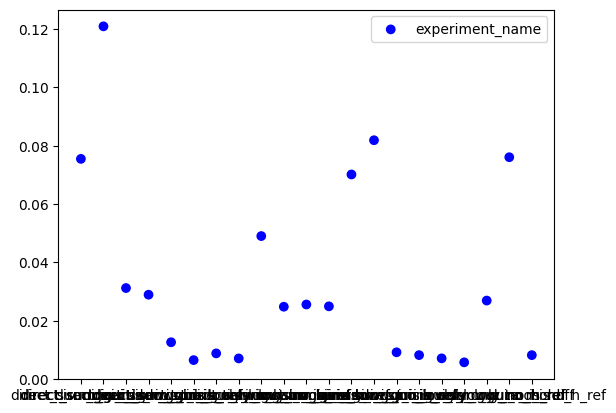

Skipping batch_size as all values are the same
Skipping num_mols as all values are the same
Skipping max_size as all values are the same


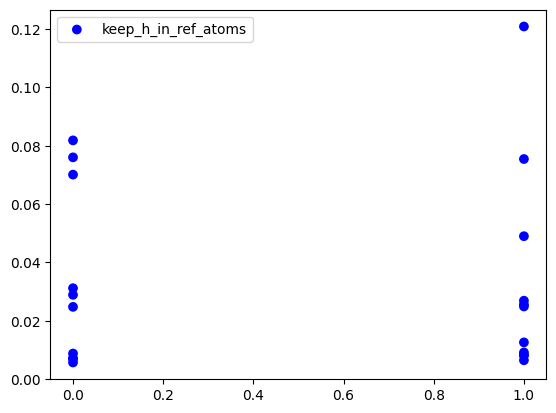

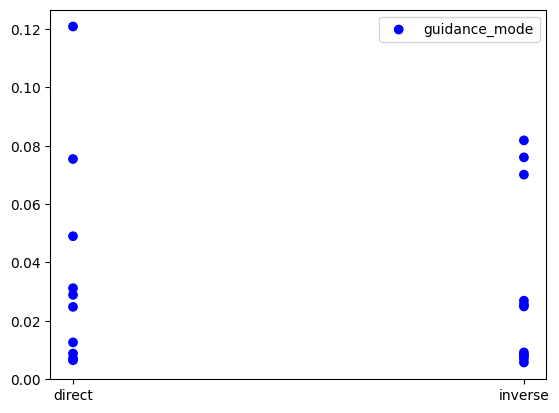

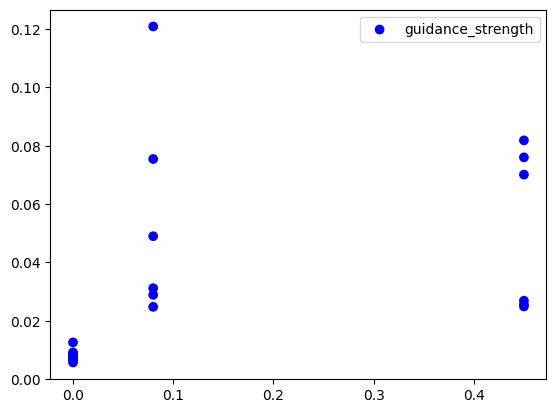

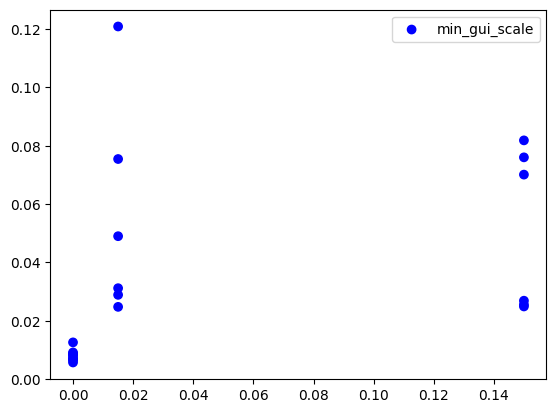

Skipping scale_mode as all values are the same
Skipping bond_guidance_strength as all values are the same
Skipping default_sigma as all values are the same


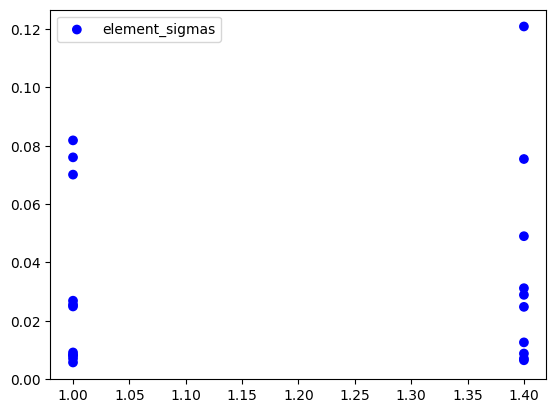

Skipping sigma_schedule as all values are the same


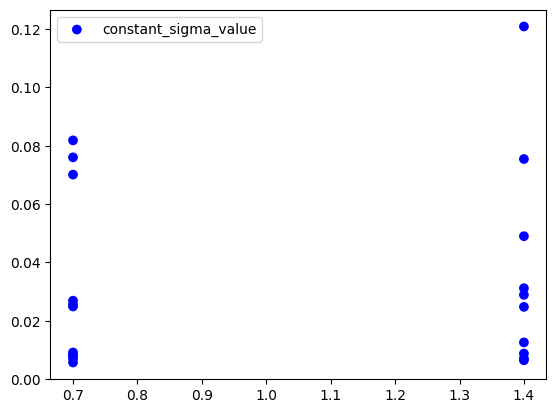

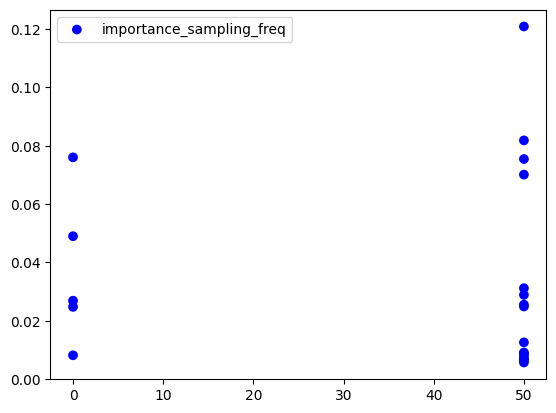

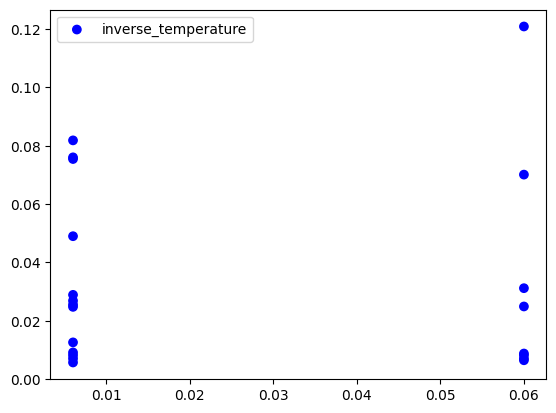

Skipping mini_batch as all values are the same
Skipping results_dir as all values are the same


In [5]:
# iterate over screened params and plot param value vs fragmented fraction
config_example = configs[idx_to_exp_map[0]]
for param in config_example.keys():
    if param != "element_sigmas":
        xs = [configs[k][param] for k in idx_to_exp_map]
    else:
        xs = [configs[k][param][7] for k in idx_to_exp_map]
    cmap = {"fractional": "blue", "absolute": "red"}
    cs = [configs[k]["scale_mode"] for k in idx_to_exp_map]
    cs = [cmap[c] for c in cs]
    if len(np.unique(xs)) == 1:
        print(f"Skipping {param} as all values are the same")
    else:
        plt.scatter(xs, fragmented_fracs, label=param, c=cs)
        plt.legend()
        plt.show()

In [6]:
penicillin_core_mol = Chem.MolFromSmiles("O=C1CC2N1CCS2")
lactam_patt = Chem.MolFromSmarts("O=C1NCC1")
thio_ring_patt = Chem.MolFromSmarts("[*]1[#16][*][*][*]1")
thio_ring_strict = Chem.MolFromSmarts("[*]1[#16][*][#7][*]1")
fp = Chem.RDKFingerprint(penicillin_core_mol)

In [7]:
fps = {k: [Chem.RDKFingerprint(mol) for mol in mols] for k, mols in out_mols.items()}

In [8]:
sims = {}
for i, fps in fps.items():
    sim_holder = np.array([Chem.DataStructs.FingerprintSimilarity(fp, f) for f in fps])
    sims[i] = sim_holder

In [9]:
mean_sims = {k: np.median(v) for k, v in sims.items()} 
top_sims = {k: np.mean(np.sort(v)[-5:]) for k, v in sims.items()} 
mean_logdens = {k: np.median(v) for k, v in out_logdens.items()} 
top_logdens = {k: np.mean(np.sort(v)[-5:]) for k, v in out_logdens.items()} 
mean_logdens_no_h = {k: np.median(v) for k, v in out_no_h_logdens.items()}
top_logdens_no_h = {k: np.mean(np.sort(v)[-5:]) for k, v in out_no_h_logdens.items()}

In [10]:
has_lactam = {k: [mol.HasSubstructMatch(lactam_patt) for mol in mols] for k, mols in out_mols.items()}
has_thio_ring = {k: [mol.HasSubstructMatch(thio_ring_patt) for mol in mols] for k, mols in out_mols.items()}
has_thio_ring_strict = {k: [mol.HasSubstructMatch(thio_ring_strict) for mol in mols] for k, mols in out_mols.items()}
has_both_strict = {k: [mol.HasSubstructMatch(lactam_patt) and mol.HasSubstructMatch(thio_ring_strict) for mol in mols] for k, mols in out_mols.items()}
has_both = {k: [mol.HasSubstructMatch(lactam_patt) and mol.HasSubstructMatch(thio_ring_patt) for mol in mols] for k, mols in out_mols.items()}

In [11]:
num_lactams = {k: np.sum(v) for k, v in has_lactam.items()}
num_thio_rings = {k: np.sum(v) for k, v in has_thio_ring.items()}
num_both = {k: np.sum(v) for k, v in has_both.items()} 
num_both_strict = {k: np.sum(v) for k, v in has_both_strict.items()}
num_both_strict

{'inv_sum_gui_is_only_low_t_no_h_ref': 0,
 'direct_sum_gui_is': 0,
 'direct_sum_gui_no_is_no_h_ref': 1,
 'direct_sum_gui_no_is': 0,
 'inv_sum_gui_no_is': 3,
 'inv_sum_gui_is_low_t': 0,
 'direct_sum_gui_is_only_low_t': 0,
 'inv_sum_gui_no_is_no_h_ref': 3,
 'direct_sum_gui_is_low_t': 0,
 'pure_moldiff': 0,
 'direct_sum_gui_is_low_t_no_h_ref': 0,
 'inv_sum_gui_is_low_t_no_h_ref': 1,
 'inv_sum_gui_is_only_no_h_ref': 0,
 'direct_sum_gui_is_no_h_ref': 0,
 'inv_sum_gui_is': 4,
 'direct_sum_gui_is_only': 0,
 'inv_sum_gui_is_only': 0,
 'direct_sum_gui_is_only_no_h_ref': 0,
 'inv_sum_gui_is_no_h_ref': 11,
 'inv_sum_gui_is_only_low_t': 0,
 'direct_sum_gui_is_only_low_t_no_h_ref': 0}

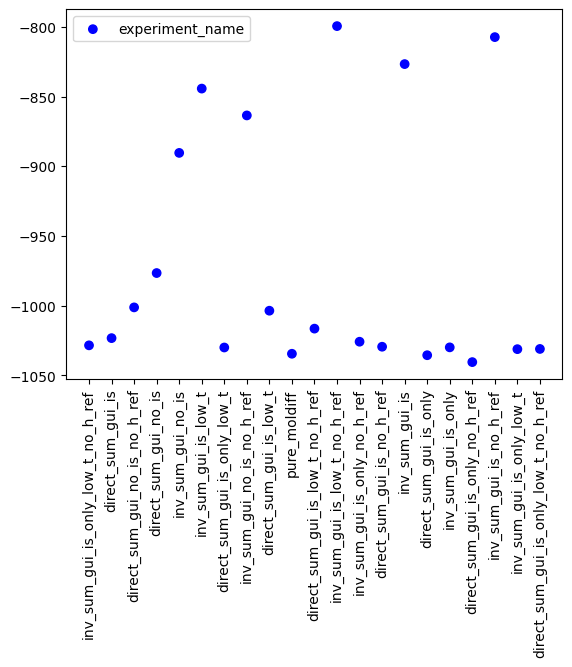

batch_size is constant
num_mols is constant
max_size is constant


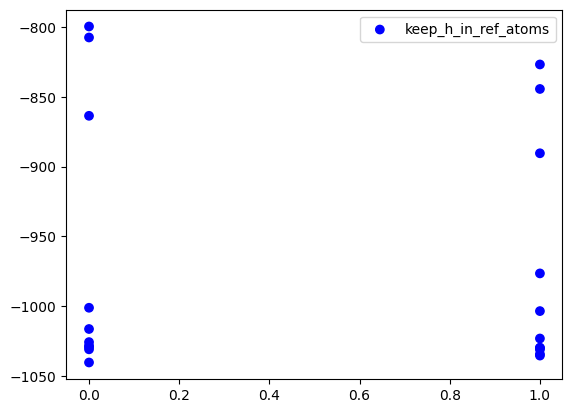

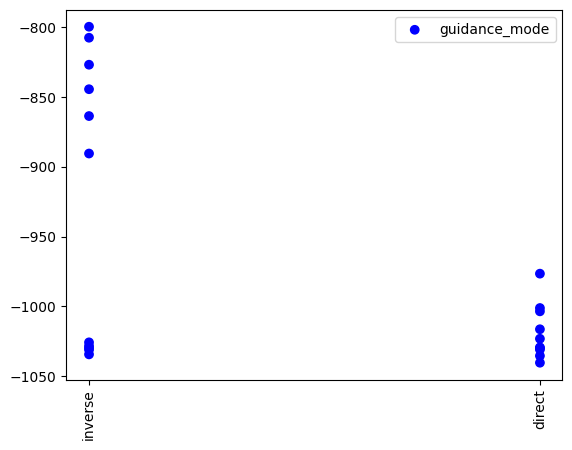

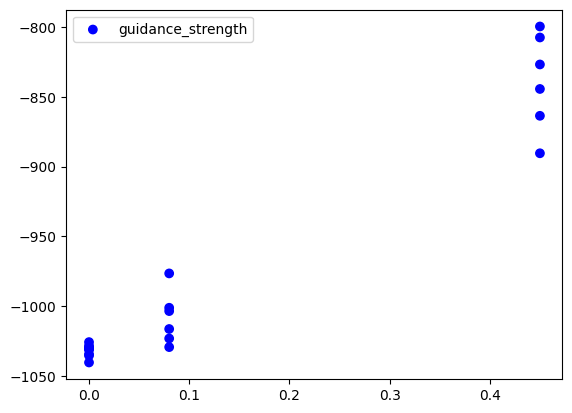

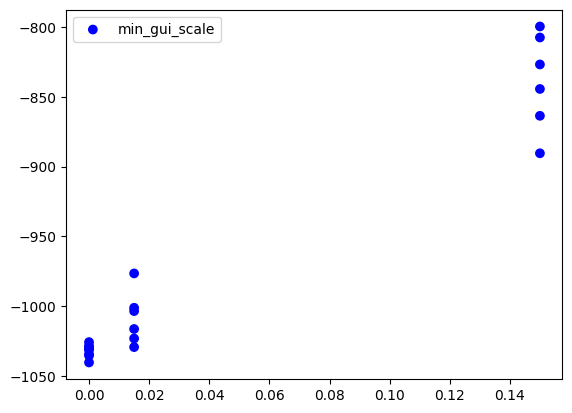

scale_mode is constant
bond_guidance_strength is constant
default_sigma is constant


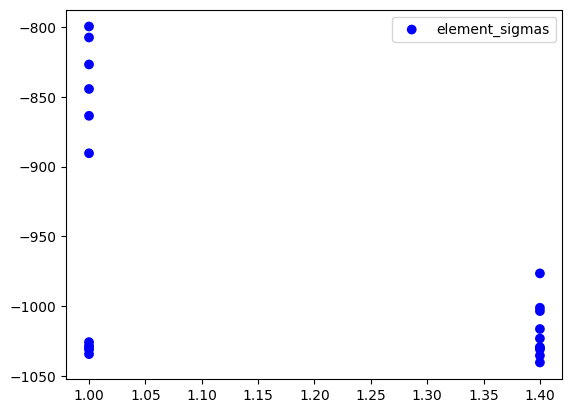

sigma_schedule is constant


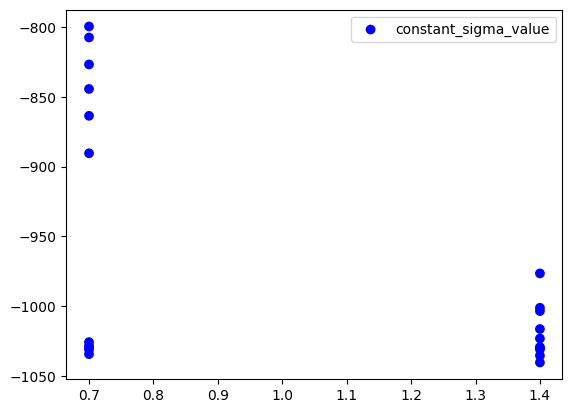

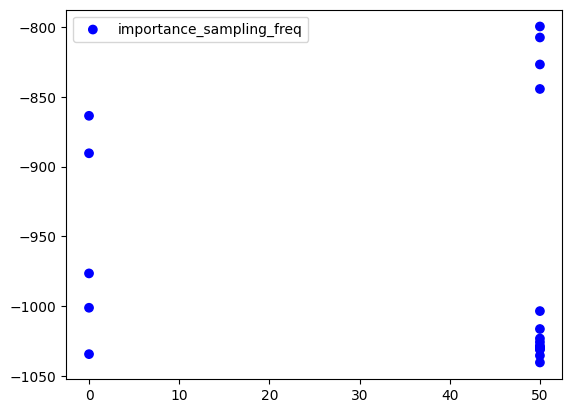

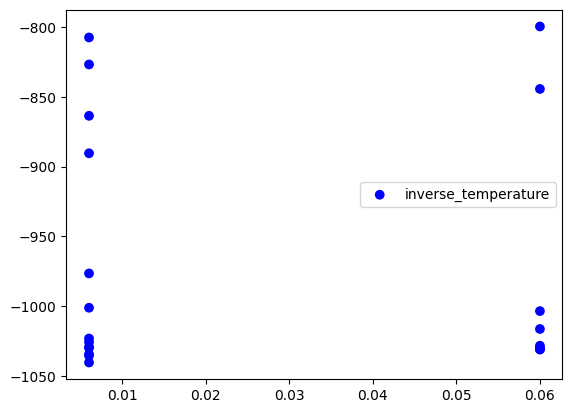

mini_batch is constant
results_dir is constant


In [12]:
# iterate over screened params and plot param value vs fragmented fraction
config_example = configs[idx_to_exp_map[0]]
to_plot = mean_logdens_no_h
vals = np.array(list(to_plot.values()))
for param in config_example.keys():
    if param != "element_sigmas":
        xs = [configs[k][param] for k in to_plot.keys()]
    else:
        xs = [configs[k][param][7] for k in to_plot.keys()]
    cmap = {"fractional": "blue", "absolute": "red"}
    cs = [configs[k]["scale_mode"] for k in to_plot.keys()]
    cs = [cmap[c] for c in cs]
    if len(np.unique(xs)) > 1:
        fig, ax = plt.subplots()
        ax.scatter(xs, vals, label=param, c=cs)
        ax.legend()
        if isinstance(xs[0], str):
            plt.xticks(rotation=90)
        plt.show()
    else:
        print(f"{param} is constant")

In [13]:
sorted(top_logdens_no_h.items(), key=lambda x: x[1])

[('direct_sum_gui_is_only_no_h_ref', -516.6885986328125),
 ('direct_sum_gui_is_only', -501.87505493164065),
 ('direct_sum_gui_is_only_low_t_no_h_ref', -489.4007995605469),
 ('inv_sum_gui_is_only', -488.2577209472656),
 ('inv_sum_gui_is_only_no_h_ref', -477.99110717773436),
 ('direct_sum_gui_is_low_t_no_h_ref', -474.3981018066406),
 ('direct_sum_gui_is_only_low_t', -465.12672119140626),
 ('direct_sum_gui_is_no_h_ref', -462.83672485351565),
 ('pure_moldiff', -456.9534484863281),
 ('inv_sum_gui_is_only_low_t', -436.9622863769531),
 ('direct_sum_gui_no_is_no_h_ref', -420.1705627441406),
 ('direct_sum_gui_is_low_t', -413.5952392578125),
 ('direct_sum_gui_no_is', -412.7587829589844),
 ('inv_sum_gui_is_only_low_t_no_h_ref', -395.06199951171874),
 ('direct_sum_gui_is', -387.60386352539064),
 ('inv_sum_gui_no_is_no_h_ref', -275.2387329101563),
 ('inv_sum_gui_is_low_t_no_h_ref', -266.03785400390626),
 ('inv_sum_gui_is', -264.7070770263672),
 ('inv_sum_gui_no_is', -263.2857421875),
 ('inv_sum_gui

In [14]:
out_logdens["inv_sum_gui_is_low_t"][909]

-381.14056396484375

In [15]:
np.argsort(out_logdens["inv_sum_gui_is_no_h_ref"])[-10:]

array([4394, 4363, 4282, 5062, 3843,  334, 1184, 5063, 1185, 1186])

In [16]:
np.argsort(has_both["inv_sum_gui_is_low_t"])[-10:]

array([1724, 1723, 1722, 1721, 1720, 1726, 5173, 2636, 2634, 3340])

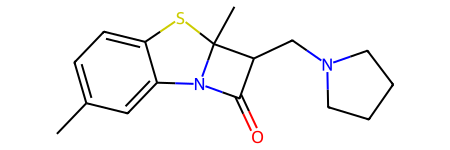

In [17]:
out_mols["inv_sum_gui_is_no_h_ref"][3843]

In [18]:
from rdkit.Chem import Draw

In [19]:
def get_highlightable_atoms(mol, *patterns):
    atom_indices = []
    for patt in patterns:
        matches = mol.GetSubstructMatches(patt)
        # want a flat list of indices, not a list of tuples
        atom_indices.extend([i for match in matches for i in match])
    if len(atom_indices) == 0:
        return None
    return atom_indices

In [20]:
four_membered_amine = Chem.MolFromSmarts("C1CNC1")

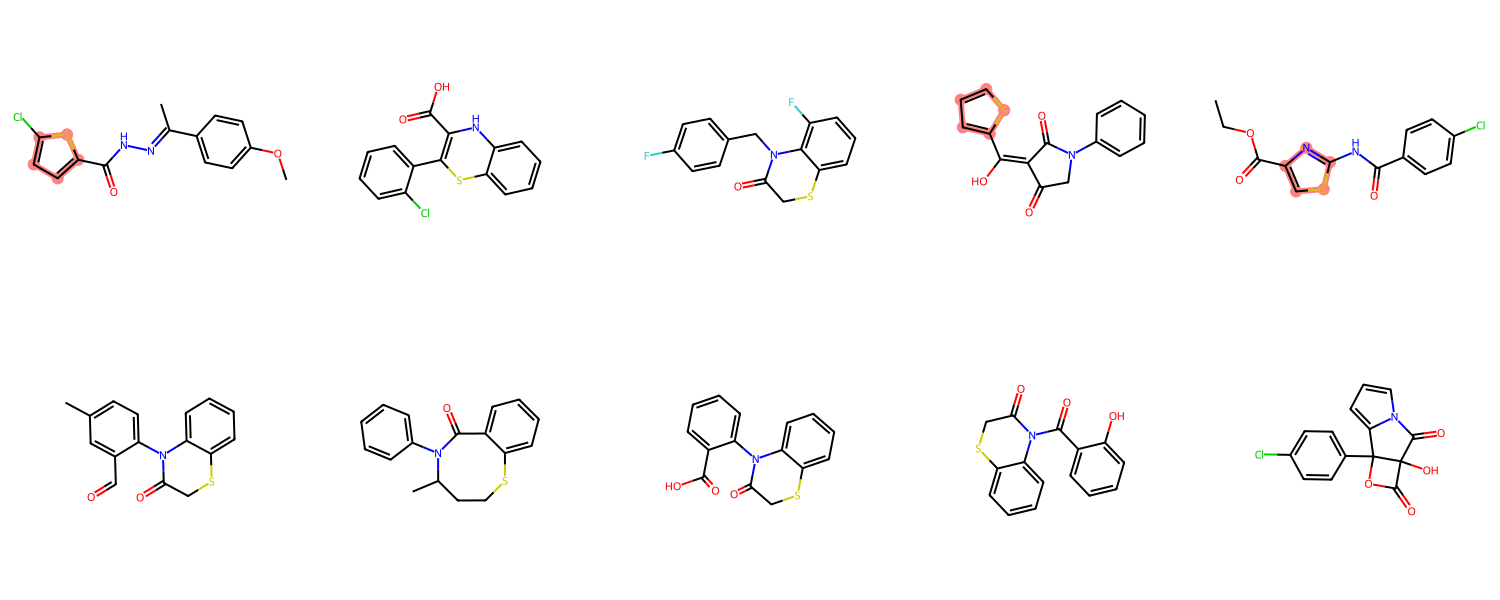

In [21]:
mols_to_draw = [out_mols["pure_moldiff"][i] for i in np.argsort(out_logdens["pure_moldiff"])[-10:]]
highlights = [get_highlightable_atoms(mol, lactam_patt, thio_ring_patt, four_membered_amine) for mol in mols_to_draw]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300, 300), highlightAtomLists=highlights)
img

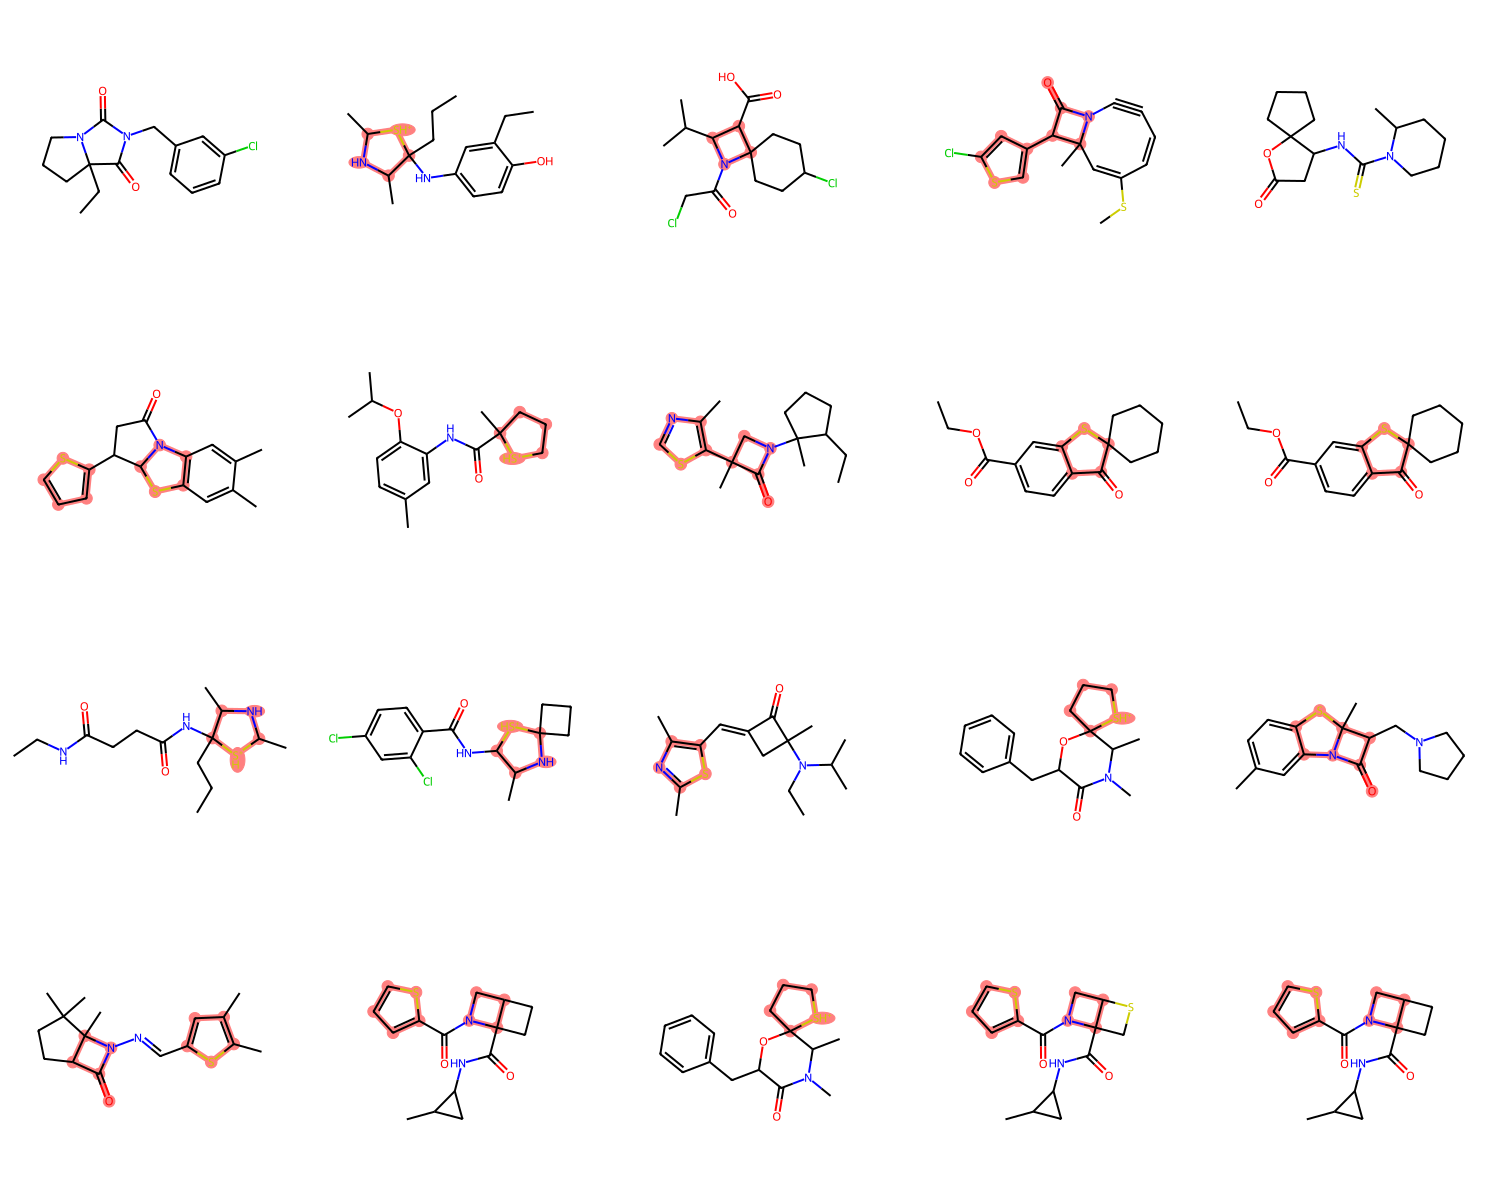

In [26]:
mols_to_draw = [out_mols["inv_sum_gui_is_no_h_ref"][i] for i in np.argsort(out_logdens["inv_sum_gui_is_no_h_ref"])[-20:]]
highlights = [get_highlightable_atoms(mol, lactam_patt, thio_ring_patt, four_membered_amine) for mol in mols_to_draw]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300, 300), highlightAtomLists=highlights)
img

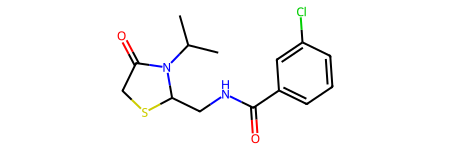

In [45]:
out_mols["pure_moldiff"][2704]

In [198]:
Chem.MolToSmiles(out_mols[29][1292])

'CC12SCC(=O)N1c1ccc(Cl)cc1-c1ccccc12'

In [79]:
np.where(has_lactam[6])

(array([  52,   69,   95,  164,  240,  284,  379,  559,  657,  798,  994,
        1015, 1099, 1159, 1334]),)

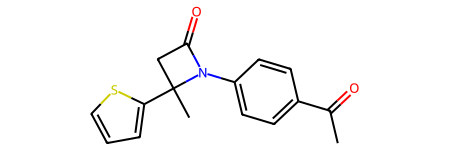

In [87]:
out_mols[6][559]